In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.frozen import FrozenEstimator
import shap

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) 
sns.set_theme(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')

In [2]:
#load data
cvd_data = pd.read_csv('data/cardio_data.csv', delimiter=';')

In [3]:
print("=== Dataset Info ===")
cvd_data.info()

print("=== Summary Statistics ===")
display(cvd_data.describe())

print("=== Unique Value Counts ===")
display(cvd_data.nunique())

print("=== Head ===")
display(cvd_data.head())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
=== Summary Statistics ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


=== Unique Value Counts ===


id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

=== Head ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
#make a copy of data
cleaned_cvd_data = pd.DataFrame(cvd_data)

cleaned_cvd_data.age = cleaned_cvd_data.age // 365
cleaned_cvd_data.gender = cleaned_cvd_data.gender.replace({1:0, 2:1})

#convert negative bp to positive
cleaned_cvd_data.ap_hi = cleaned_cvd_data.ap_hi.abs()
cleaned_cvd_data.ap_lo = cleaned_cvd_data.ap_lo.abs()

#swap ap_hi with ap_lo where ap_hi < ap_lo
swap = cleaned_cvd_data["ap_hi"] < cleaned_cvd_data["ap_lo"]
cleaned_cvd_data.loc[swap, ["ap_hi", "ap_lo"]] = (
    cleaned_cvd_data.loc[swap, ["ap_lo", "ap_hi"]].values
)

#create BMI feature
cleaned_cvd_data["height_m"] = cleaned_cvd_data["height"] / 100
cleaned_cvd_data["bmi"] = cleaned_cvd_data["weight"] / (cleaned_cvd_data["height_m"] ** 2)

cleaned_cvd_data.drop(columns=["height_m"], inplace=True)

In [5]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_cols = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']
ordinal_cols = ['cholesterol', 'gluc']
binary_cols = ['gender', 'smoke', 'alco', 'active']

EDA of Continuous Features


/tmp/ipykernel_1049851/1387974098.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cleaned_cvd_data, x='age_group', palette='pastel', order=age_group_labels)


Text(0.5, 1.0, 'Count by Age Group')

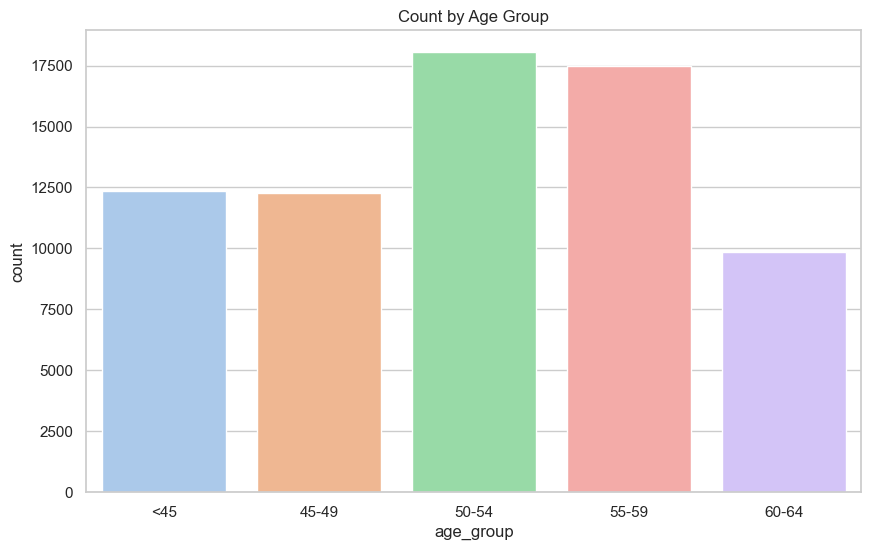

In [6]:
age_group_bin = [0, 45, 50, 55, 60, 65]
age_group_labels = ['<45', '45-49', '50-54', '55-59', '60-64']

cleaned_cvd_data['age_group'] = pd.cut(
    cleaned_cvd_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

sns.countplot(data=cleaned_cvd_data, x='age_group', palette='pastel', order=age_group_labels)
plt.title('Count by Age Group')

'Histogram of age'

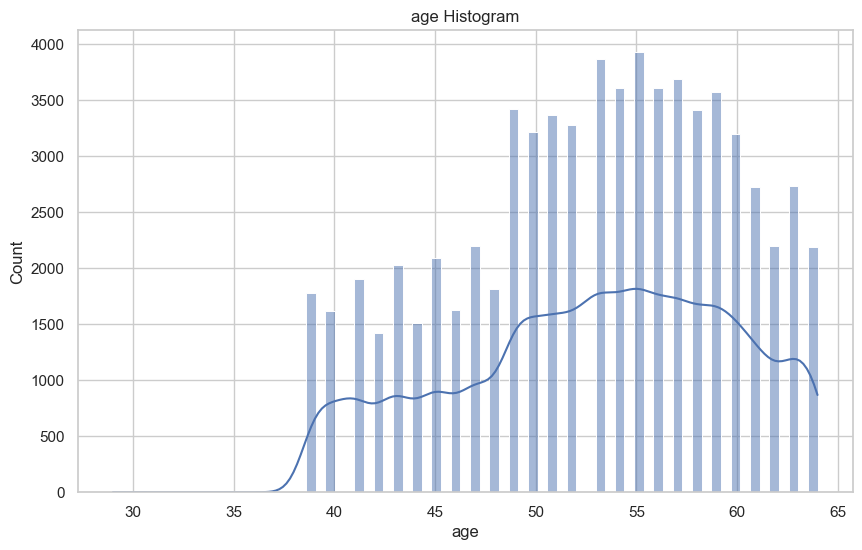

'Histogram of height'

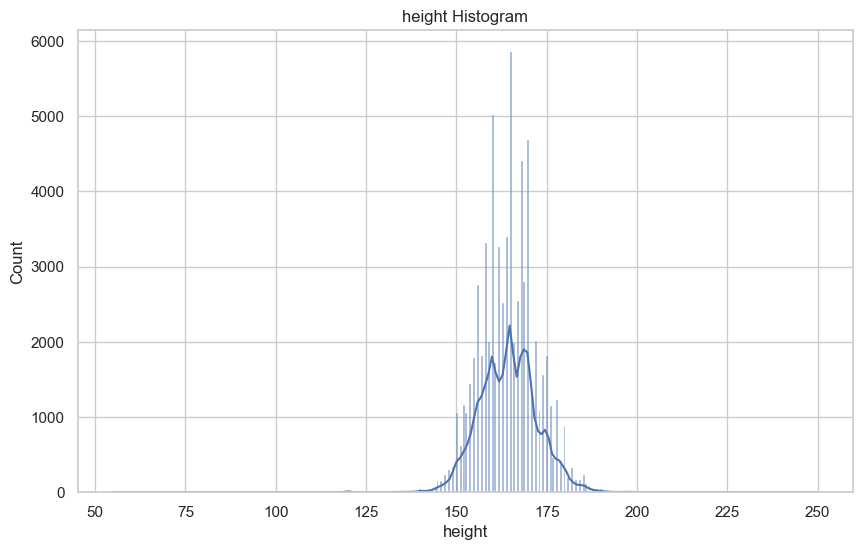

'Histogram of weight'

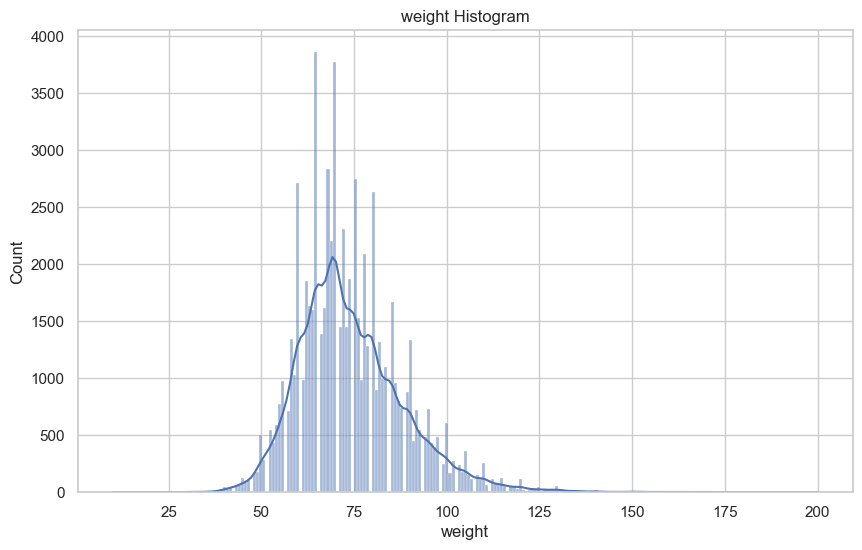

'Histogram of bmi'

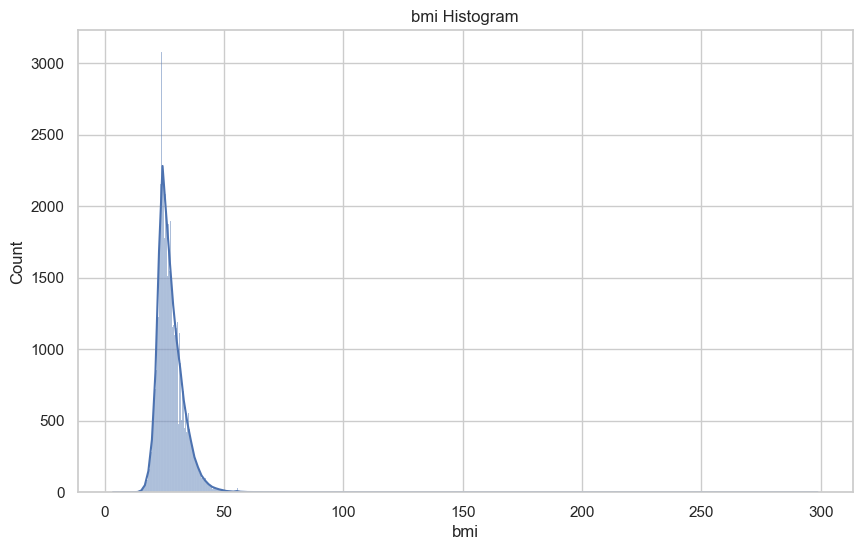

'Histogram of ap_hi'

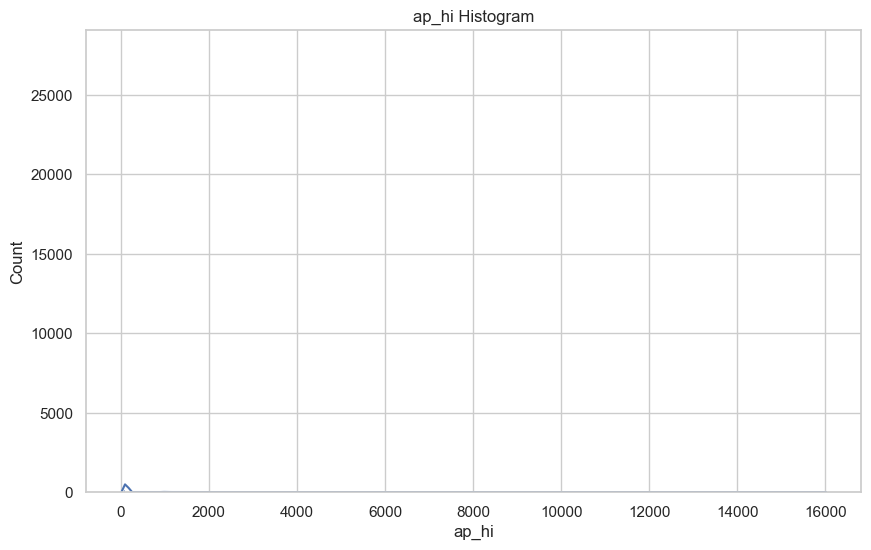

'Histogram of ap_lo'

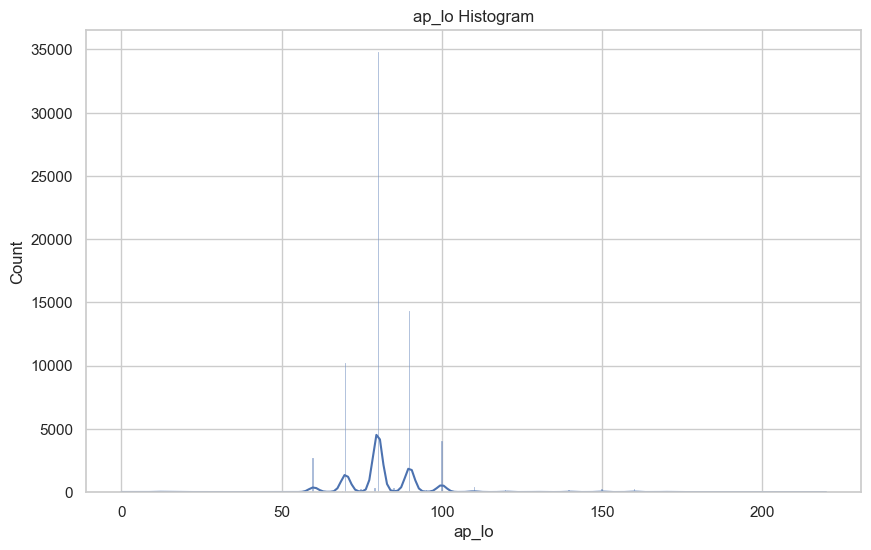

In [7]:
#hist for continuous features
for col in cont_cols:
    display(f"Histogram of {col}")
    sns.histplot(data=cleaned_cvd_data, x = col, kde = True)
    plt.title(f'{col} Histogram')
    plt.show()

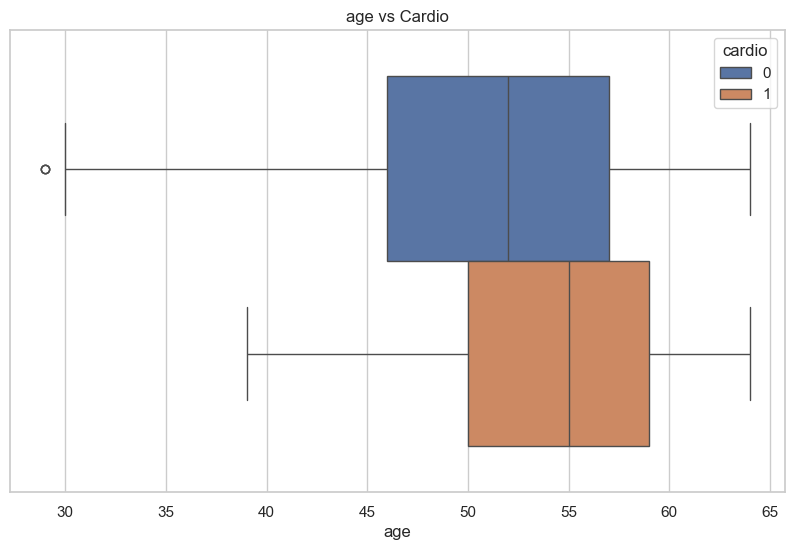

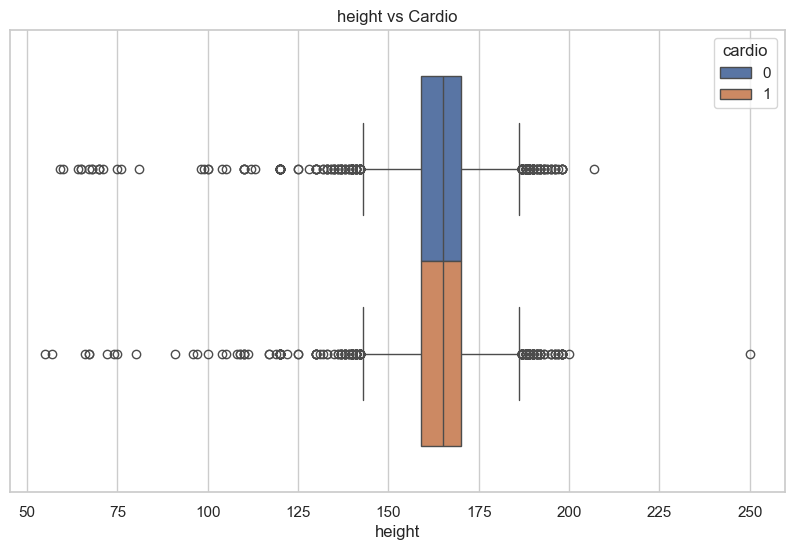

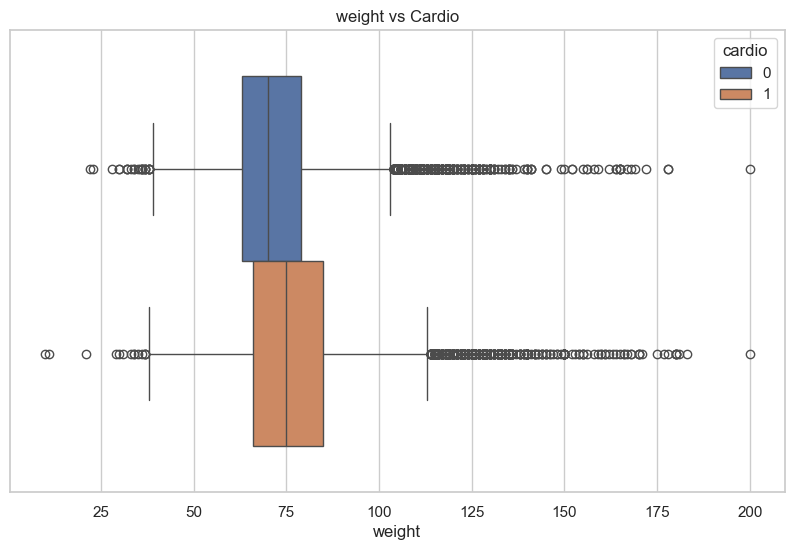

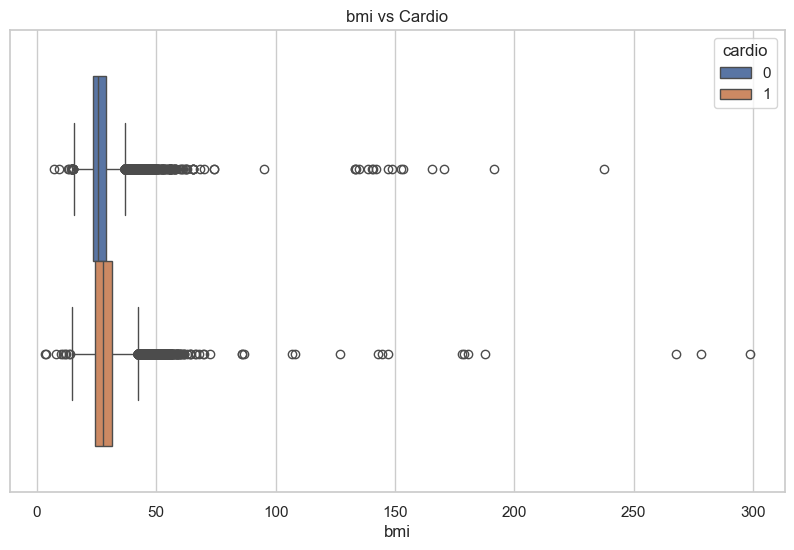

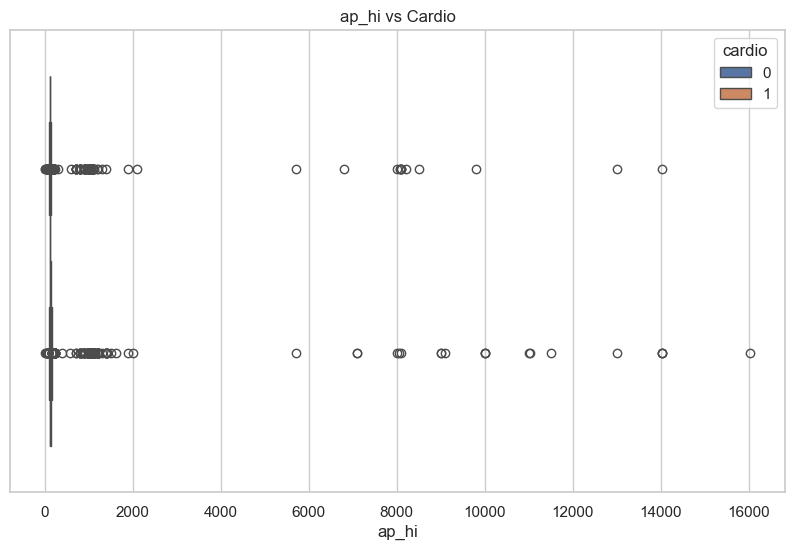

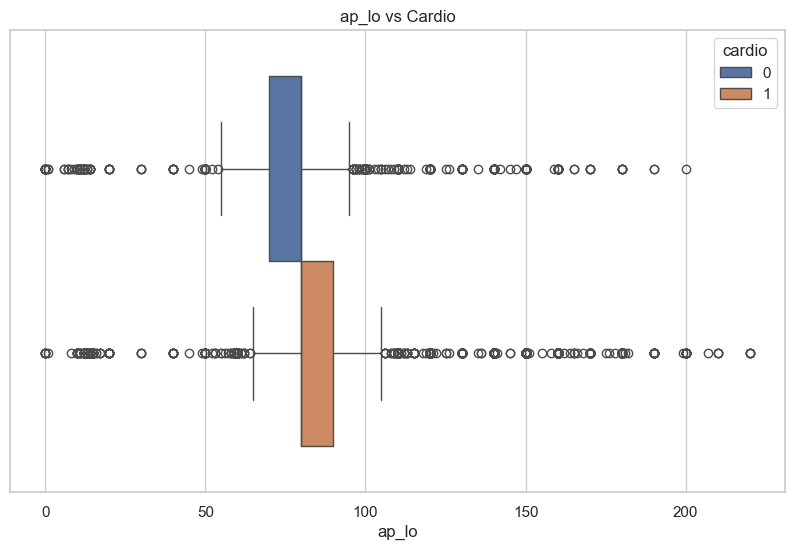

In [8]:
#Boxplot for continuous features
for col in cont_cols:
    sns.boxplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

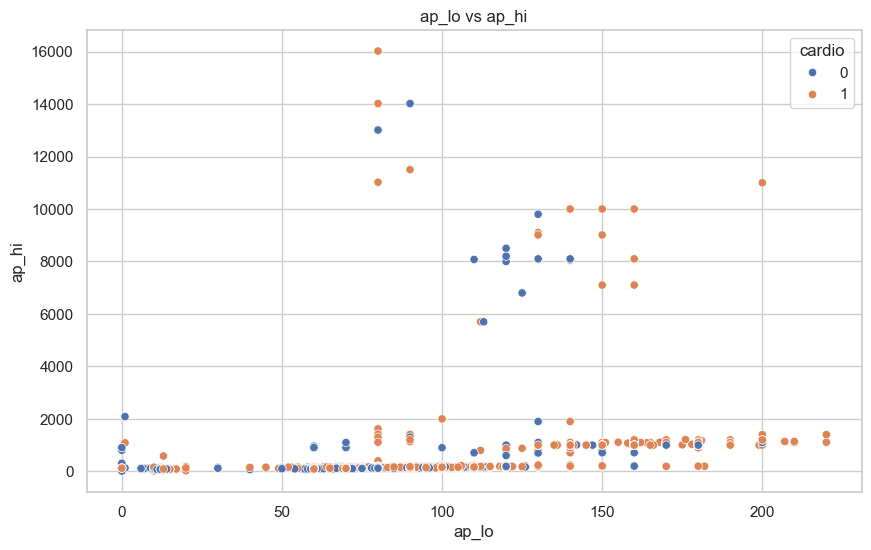

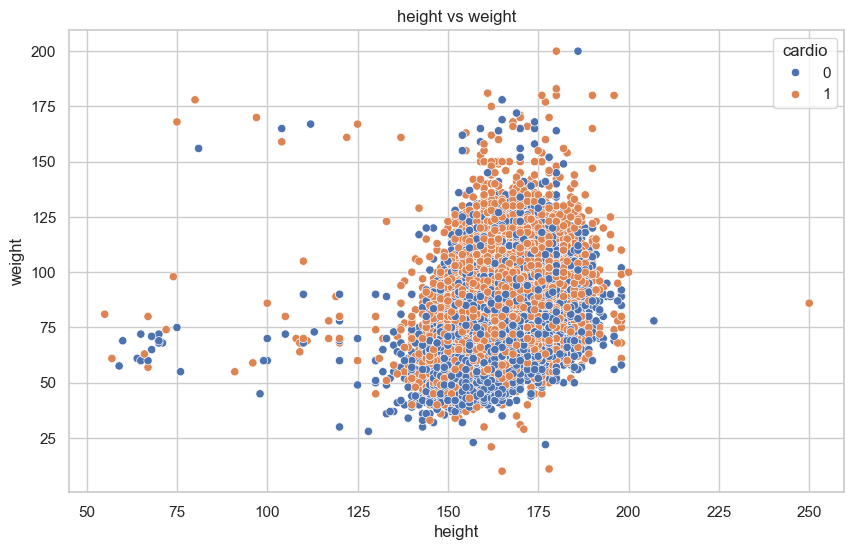

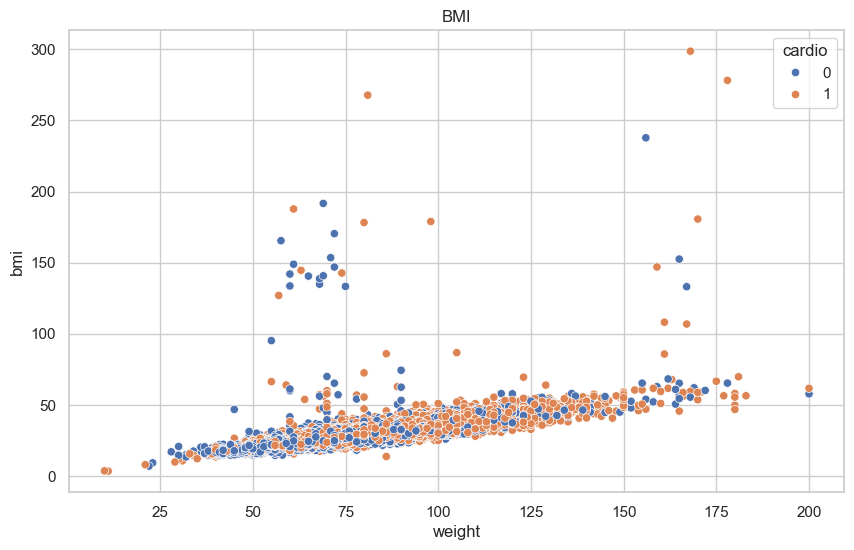

In [9]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x='height', y='weight', hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.title('BMI')
plt.show()

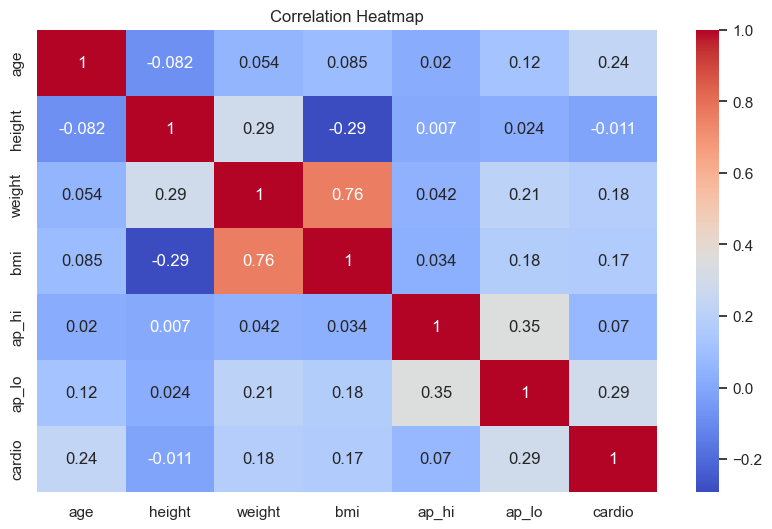

In [10]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Observation**:
ap_hi, ap_lo, weight and height has outlier and contains unrealistic data.

Medically, 70 > ap_hi > 240 is unrealistic,


In [11]:
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_hi <= 240) & (cleaned_cvd_data.ap_hi >= 70)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_lo <= 200) & (cleaned_cvd_data.ap_lo >= 40)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.bmi <= 60) & (cleaned_cvd_data.bmi >= 10)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.height < 200) & (cleaned_cvd_data.height > 120)]

display(cleaned_cvd_data.shape)

(68671, 15)

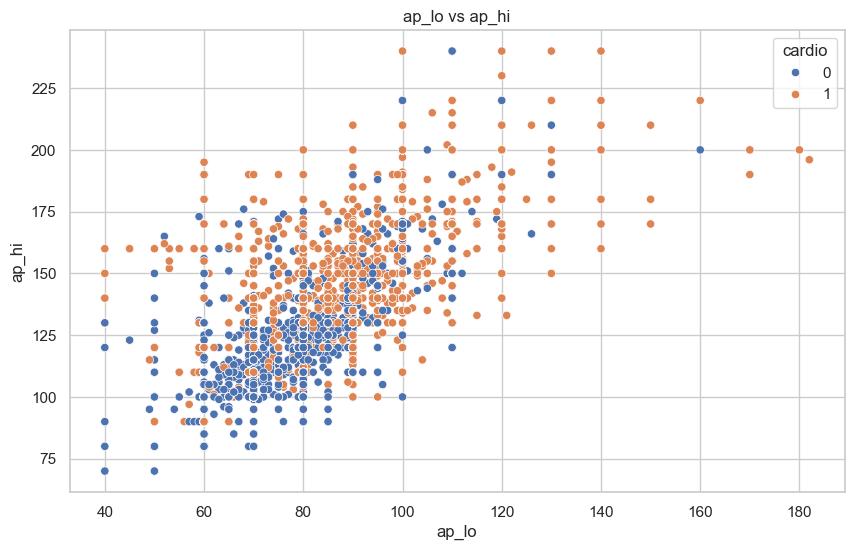

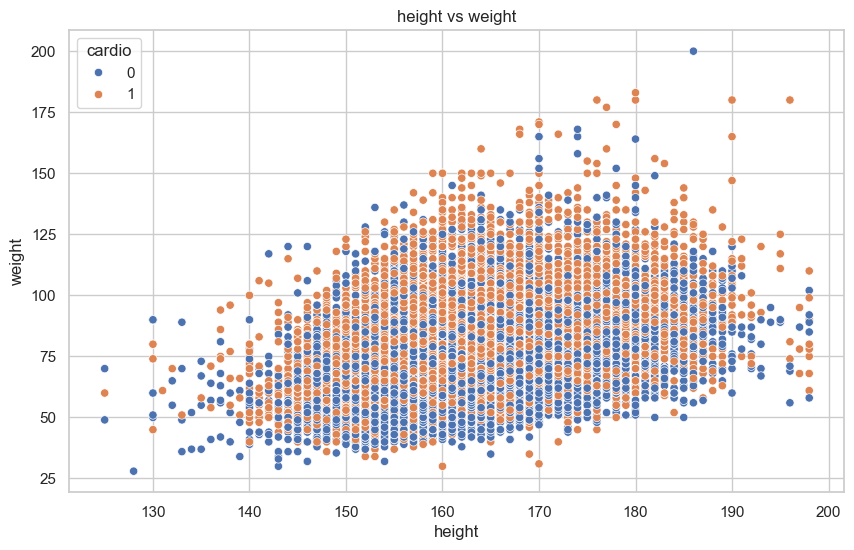

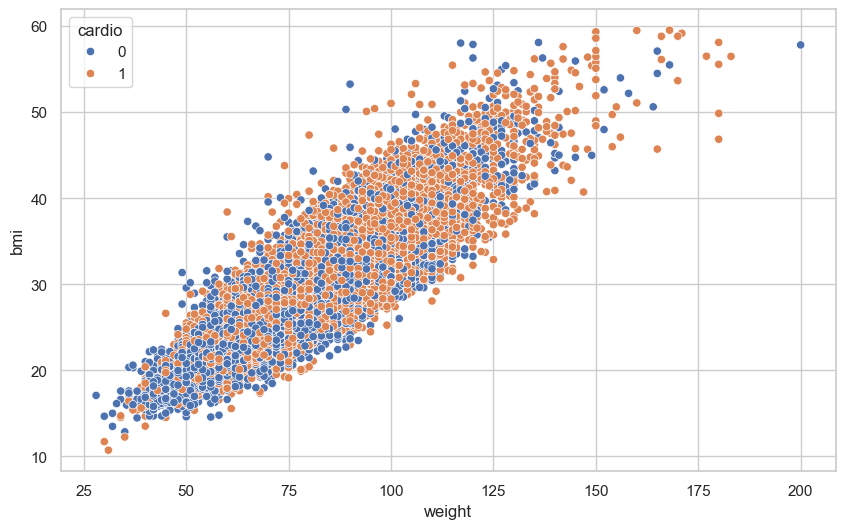

In [12]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x="height", y="weight", hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.show()

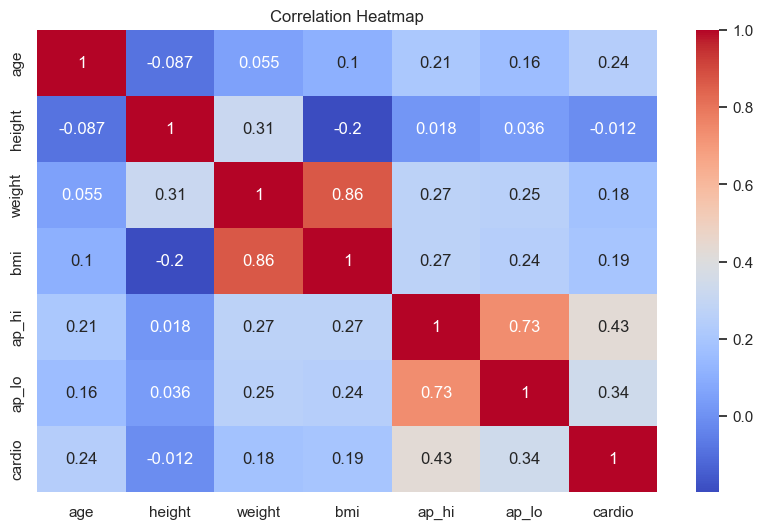

In [13]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Categorical Feature EDA


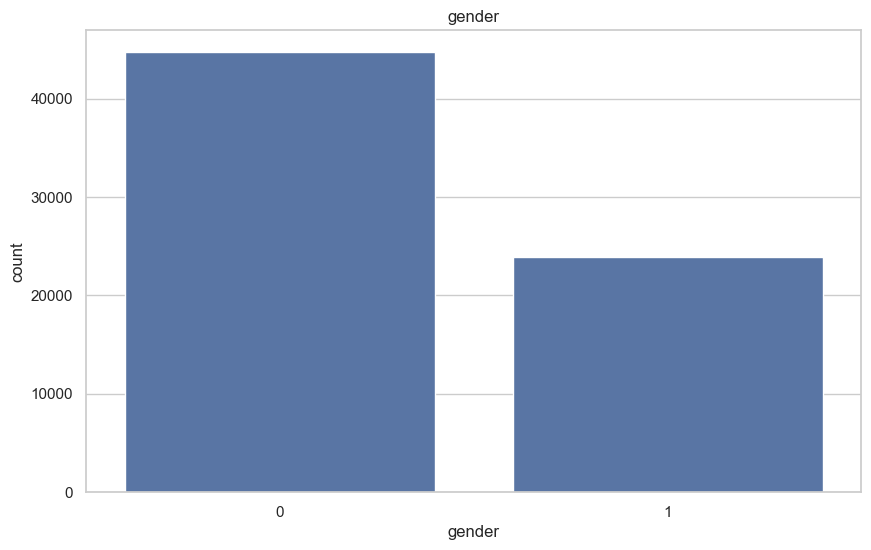

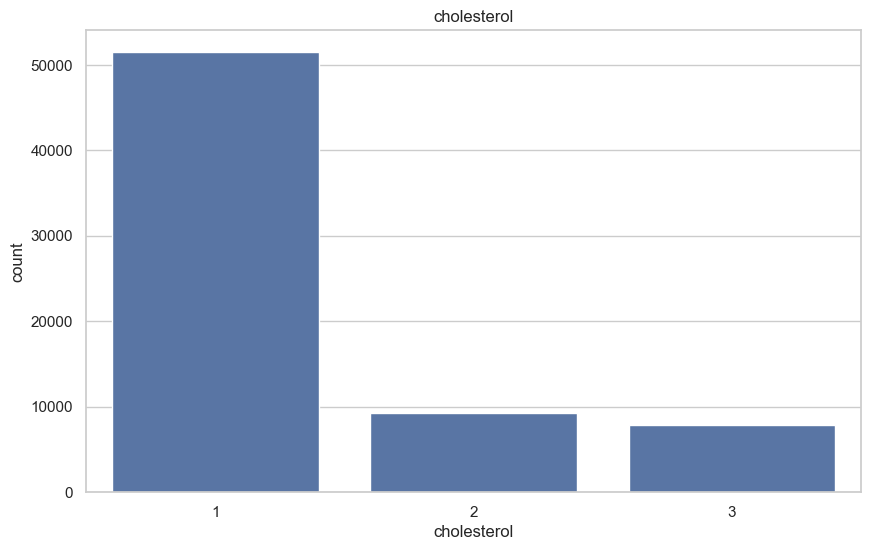

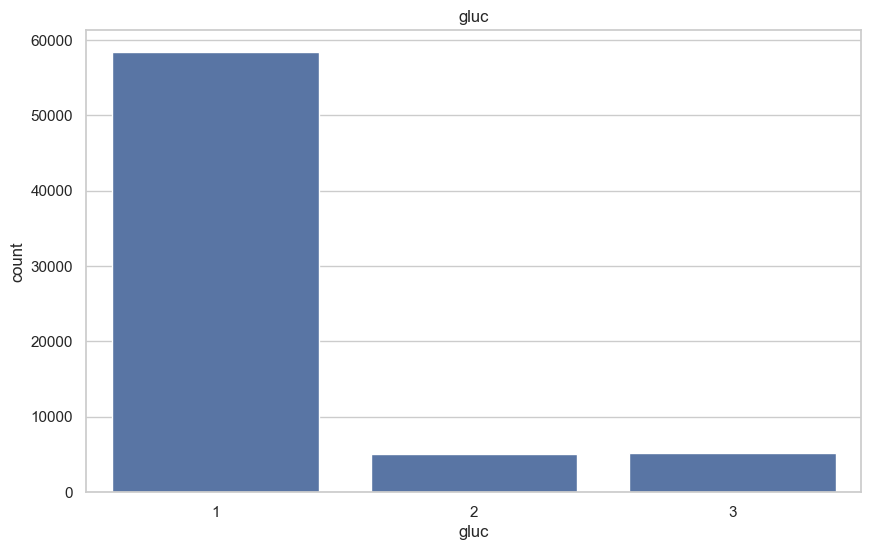

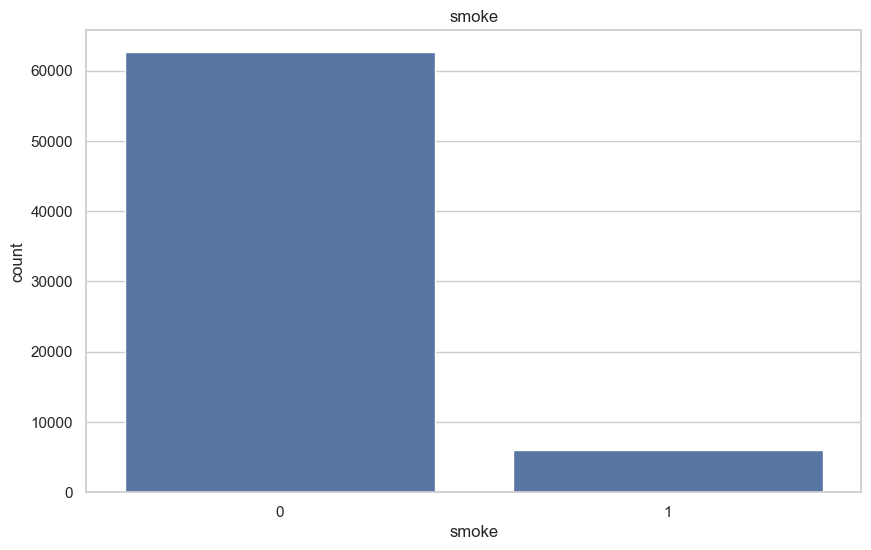

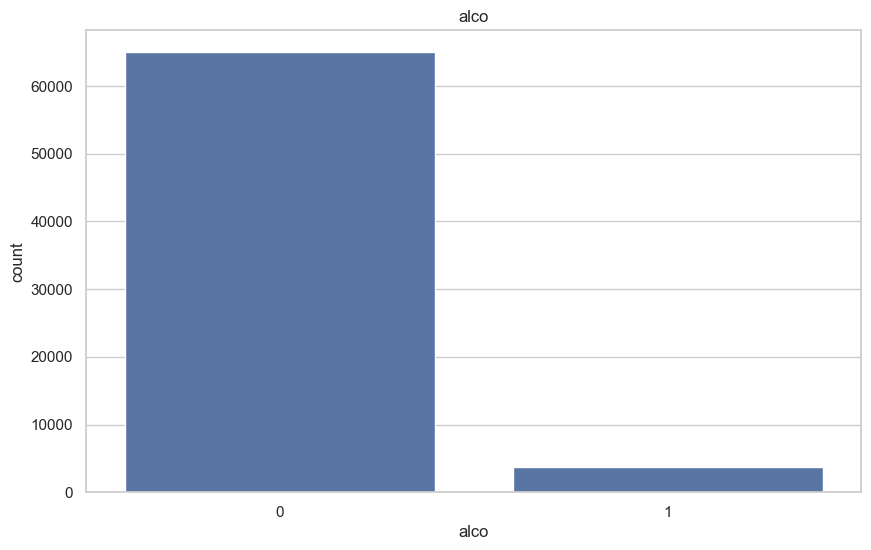

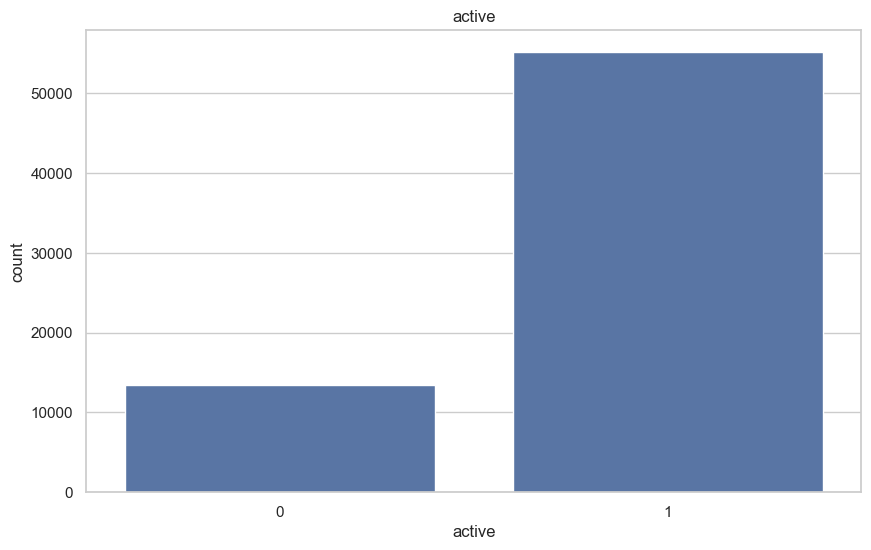

In [14]:
#Countplot of categorical features
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col)
    plt.title(f"{col}")
    plt.show()

Bivariate EDA


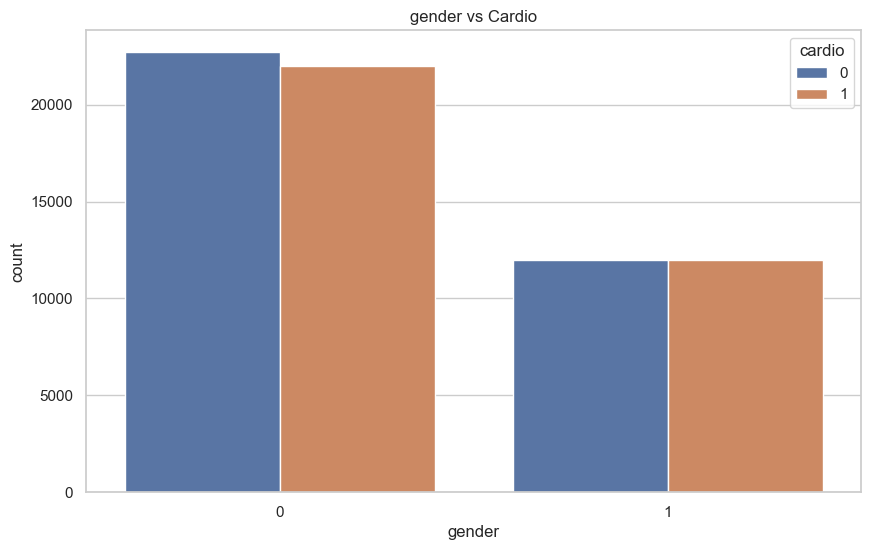

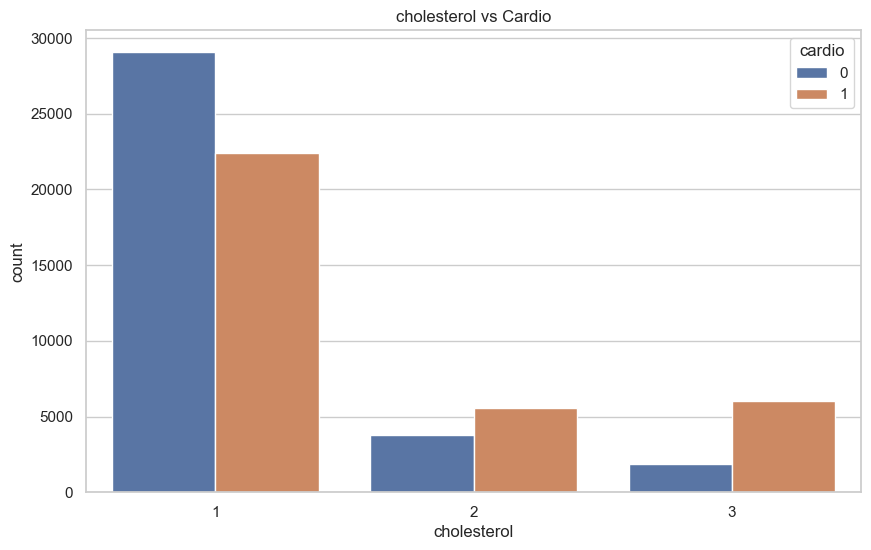

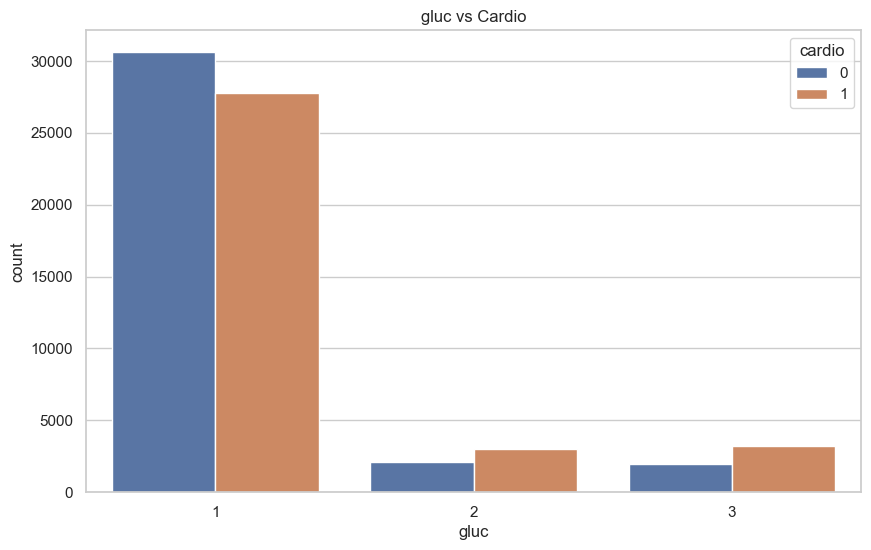

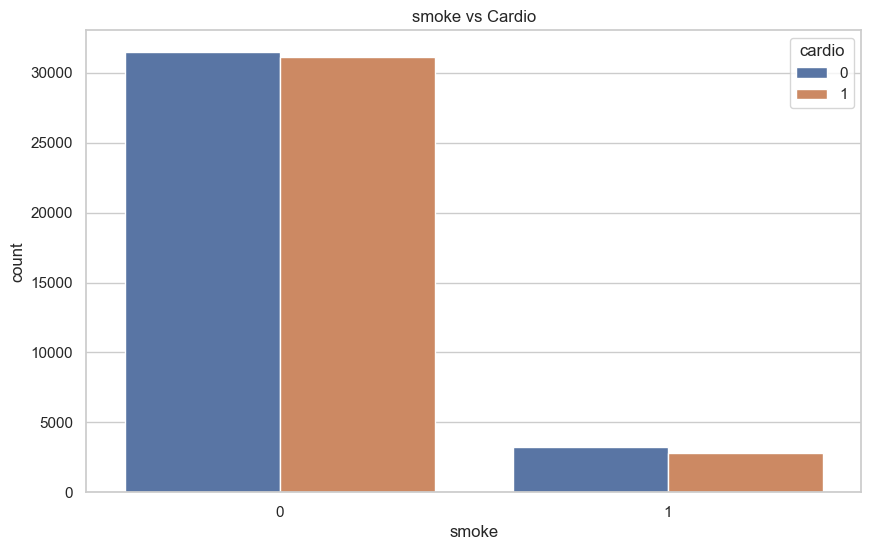

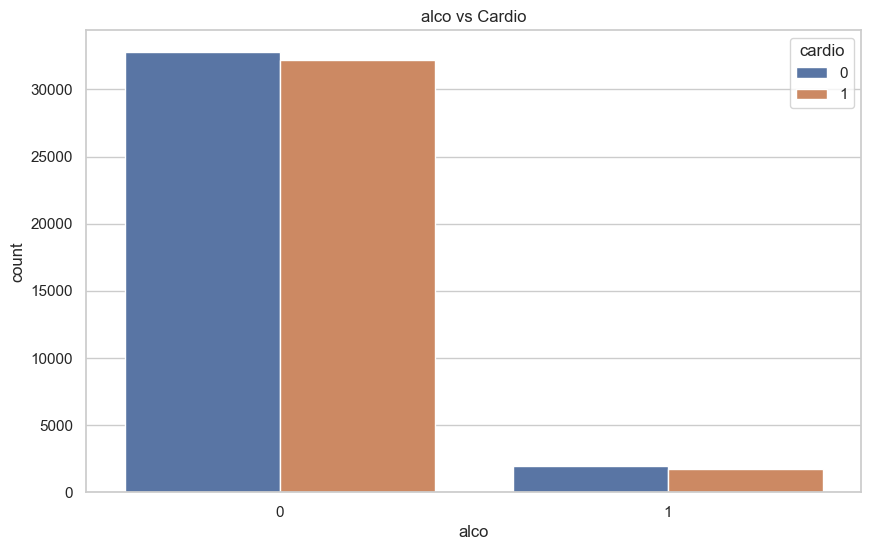

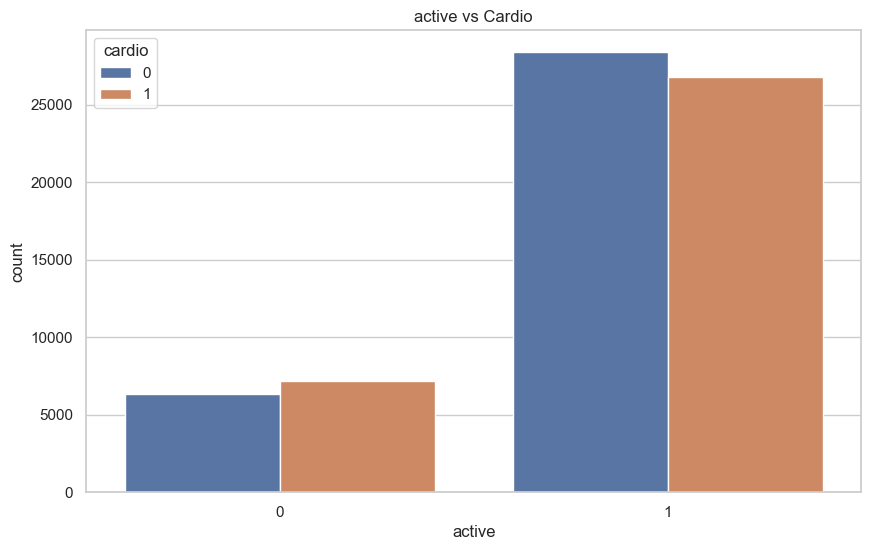

In [15]:
# relation between categorical features and cardio
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

<Axes: xlabel='cardio', ylabel='count'>

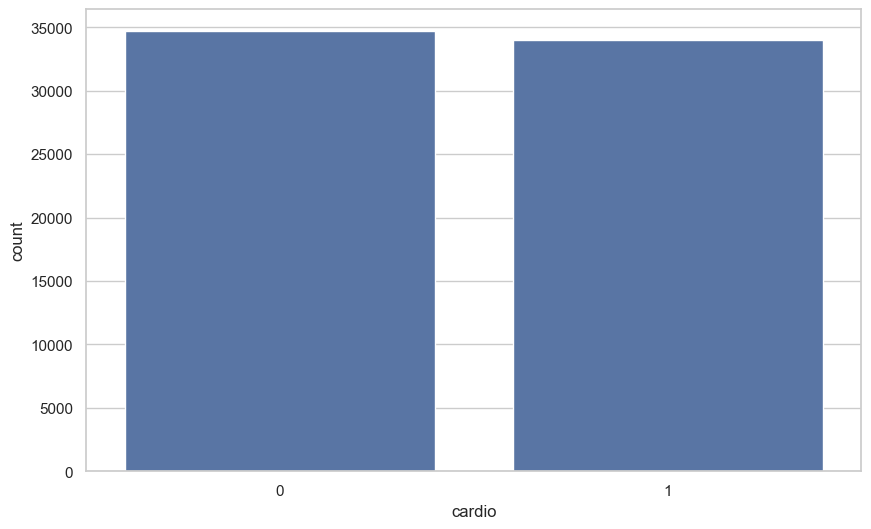

In [16]:
# Target Feature Distribution
sns.countplot(data=cleaned_cvd_data,x='cardio')

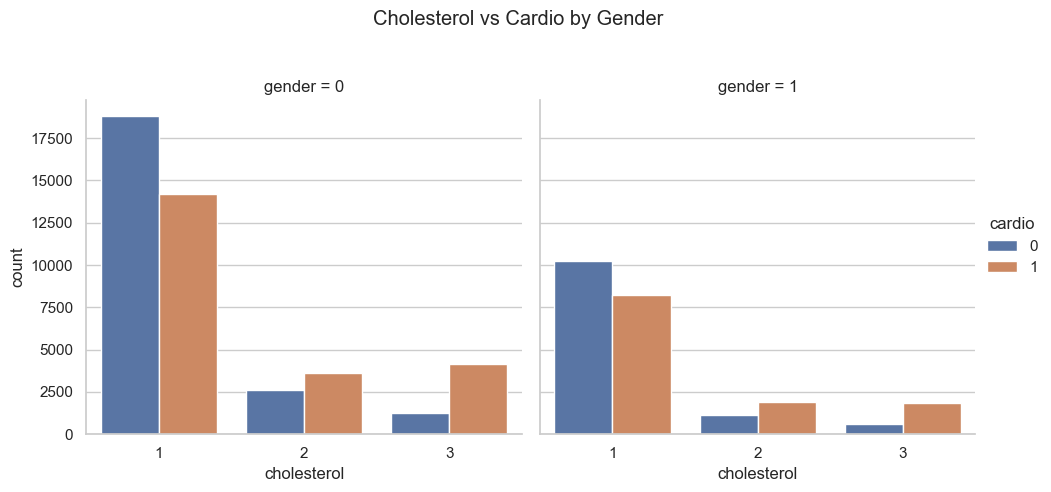

In [17]:
sns.catplot(x='cholesterol', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Cholesterol vs Cardio by Gender')
plt.show()

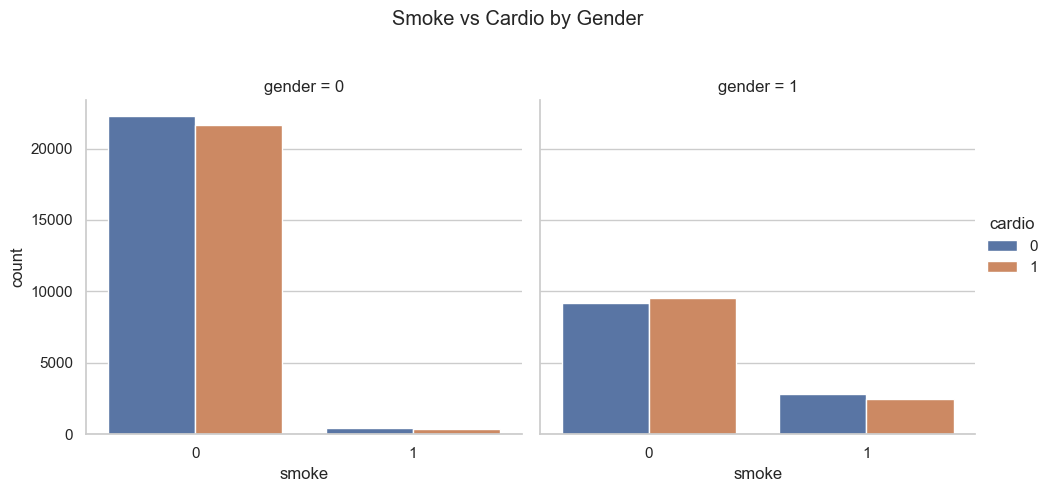

In [18]:
sns.catplot(x='smoke', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Smoke vs Cardio by Gender')
plt.show()

Split Train Validation Test: 70/10/20

In [19]:
#stratify on age, gender and cardio for fairness
cleaned_cvd_data['stratify_col'] = cleaned_cvd_data['cardio'].astype(str) + '_' + cleaned_cvd_data['gender'].astype(str) + '_' + cleaned_cvd_data['age_group'].astype(str)

train_validation_data, test_data = train_test_split(
    cleaned_cvd_data,
    test_size=0.20,
    stratify=cleaned_cvd_data['stratify_col'],
    random_state=42
)

In [20]:
train_data, validation_data = train_test_split(train_validation_data, test_size=0.125, stratify=train_validation_data['stratify_col'], random_state=42)

In [21]:
#drop unnecessary columns
drop_cols = ['id', 'stratify_col', 'age_group', 'bmi']
cont_cols.remove('bmi')

train_data.drop(columns=drop_cols, inplace=True)
validation_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

In [22]:
X_train = train_data.drop('cardio', axis=1)
y_train = train_data['cardio']

X_validation = validation_data.drop('cardio', axis=1)
y_validation = validation_data['cardio']

X_test = test_data.drop('cardio', axis=1)
y_test = test_data['cardio']

Model Preprocessor
- Scaling Numeric columns
-  One Hot Encoding ordinal columns

In [23]:
pre_processor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), cont_cols),
    ('cat', OneHotEncoder(), ordinal_cols),
    ('pass', 'passthrough', binary_cols)
], remainder='drop')

Hyperparameter Tuning with 5 fold grid search cross validation

In [24]:
model_names = ['logistic_regression', 'knn', 'random_forest', 'xgboost', 'svc']

In [25]:
#cross validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
gs_models = {
    'svc': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', SVC(random_state=42))
        ]),
        'param_grid': [
            {
                'model__kernel': ['rbf'],
                'model__C': [0.1, 1, 10],
                'model__gamma': ['scale', 'auto', 0.001, 0.01],
            },
        ]
    },
    'logistic_regression': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', LogisticRegression(random_state=42))
        ]),
        'param_grid': [
            {
                'model__penalty': ['l1'],
                'model__solver': ['liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['l2'],
                'model__solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['none'],
                'model__solver': ['lbfgs', 'newton-cg', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['elasticnet'],
                'model__solver': ['saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__l1_ratio': [0.1, 0.5, 0.9],
                'model__max_iter': [1000, 2000, 3000, 5000]            
            }
        ]
    },
    'knn': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', KNeighborsClassifier())
        ]),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            'model__weights': ['uniform', 'distance',],
            'model__p': [1, 2],
        }
    },
    'random_forest': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 20, 30, None],
            'model__bootstrap': [True],
            'model__criterion': ['gini'],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'xgboost': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__min_child_weight': [1, 5, 10],
            'model__gamma': [0.0, 0.1, 0.5],
            'model__subsample': [0.8],
            'model__colsample_bytree': [0.8],
            'model__reg_alpha': [0, 0.01]
        }
    },
}

In [27]:
grid_search_results = {}

for name, gs in gs_models.items():
    print(f"Running grid search for: {name}")
    gs = GridSearchCV(gs['pipeline'], gs['param_grid'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best_params_clean = {k.replace('model__', ''): v for k, v in gs.best_params_.items()}
    
    grid_search_results[name] = {
        'best_params': best_params_clean,
        'best_score': gs.best_score_,
        'best_estimator': gs.best_estimator_
    }

Running grid search for: svc
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running grid search for: logistic_regression
Fitting 5 folds for each of 364 candidates, totalling 1820 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
420 fits failed out of a to

Running grid search for: knn
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Running grid search for: random_forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running grid search for: xgboost
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [28]:
for name, res in grid_search_results.items():
    print(f"Best parameters for {name}: {res['best_params']}")
    print(f"Best ROC-AUC for {name}: {res['best_score']:.4f}")

Best parameters for svc: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best ROC-AUC for svc: 0.7934
Best parameters for logistic_regression: {'C': np.float64(0.1), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC for logistic_regression: 0.7908
Best parameters for knn: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best ROC-AUC for knn: 0.7654
Best parameters for random_forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best ROC-AUC for random_forest: 0.7995
Best parameters for xgboost: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}
Best ROC-AUC for xgboost: 0.8017


Final model training with best parameters

In [29]:
models = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42, **grid_search_results['logistic_regression']['best_params']))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier(**grid_search_results['knn']['best_params']))
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42, **grid_search_results['random_forest']['best_params']))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42, eval_metric='logloss', **grid_search_results['xgboost']['best_params']))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True, random_state=42, **grid_search_results['svc']['best_params']))
    ])
}

In [30]:
for name, pipeline in models.items():
    print(f"Training model: {name} : Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
    pipeline.fit(X_train, y_train)

Training model: logistic_regression : Training on 48069 samples, Testing on 13735 samples
Training model: knn : Training on 48069 samples, Testing on 13735 samples
Training model: random_forest : Training on 48069 samples, Testing on 13735 samples
Training model: xgboost : Training on 48069 samples, Testing on 13735 samples
Training model: svc : Training on 48069 samples, Testing on 13735 samples


In [31]:
def get_results(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
    
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    cm = confusion_matrix(y, y_pred, normalize='true')
    
    return pd.Series({
        'accuracy': accuracy,
        'rmse': rmse,
        'r2': r2,
        'recall_score': recall,
        'precision_score': precision,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'prob_true': prob_true,
        'prob_pred': prob_pred
    })

In [32]:
results_uncalibrated = pd.DataFrame()
score_metrics = ['accuracy', 'recall_score', 'rmse', 'r2', 'precision_score', 'f1_score', 'roc_auc', 'brier_score']

for name, model in models.items():    
    results_uncalibrated[name] = get_results(model, X_test, y_test)

display(results_uncalibrated.loc[score_metrics])

,logistic_regression,knn,random_forest,xgboost,svc
accuracy,0.727994,0.71387,0.732799,0.735275,0.730251
recall_score,0.664264,0.686479,0.657349,0.684861,0.659997
rmse,0.521542,0.534912,0.516914,0.514514,0.519373
r2,-0.088138,-0.144642,-0.068915,-0.059012,-0.079109
precision_score,0.756408,0.721732,0.769151,0.757034,0.762925
f1_score,0.707348,0.703665,0.708869,0.719141,0.707738
roc_auc,0.792033,0.767164,0.800709,0.800723,0.79464
brier_score,0.186758,0.199818,0.181402,0.180587,0.18387


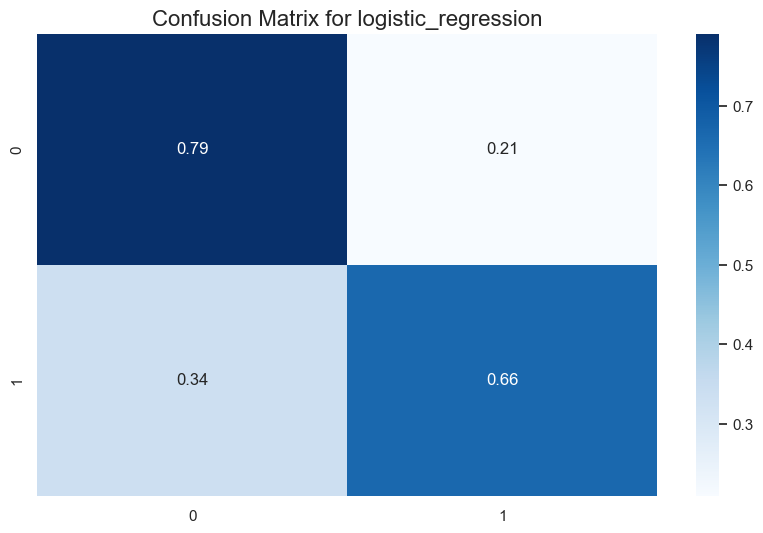

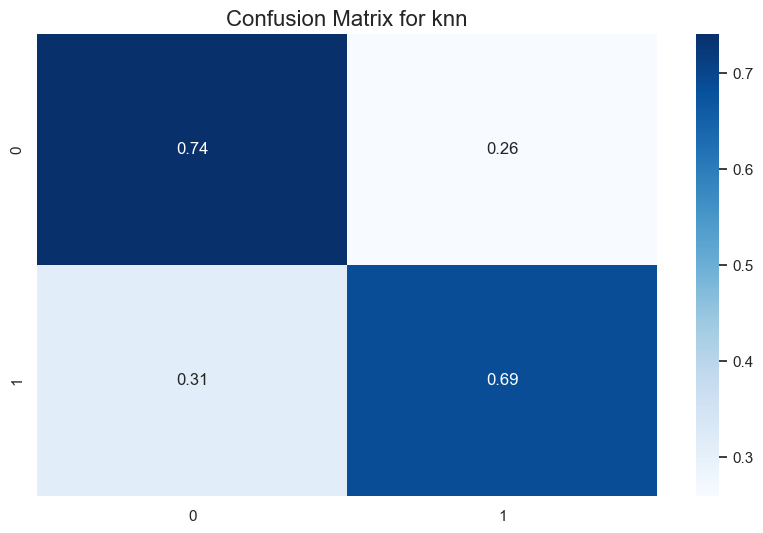

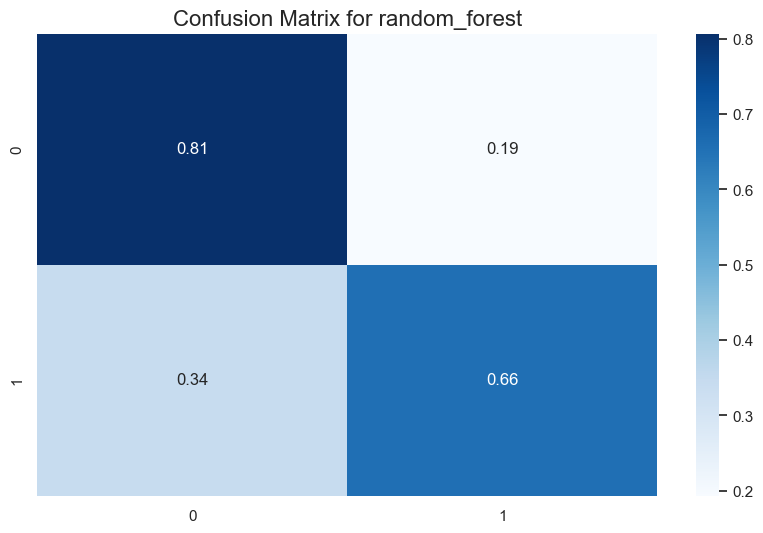

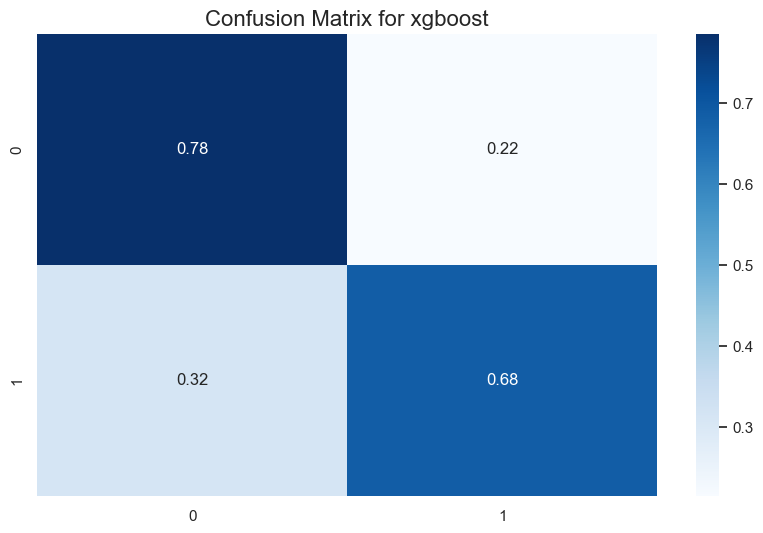

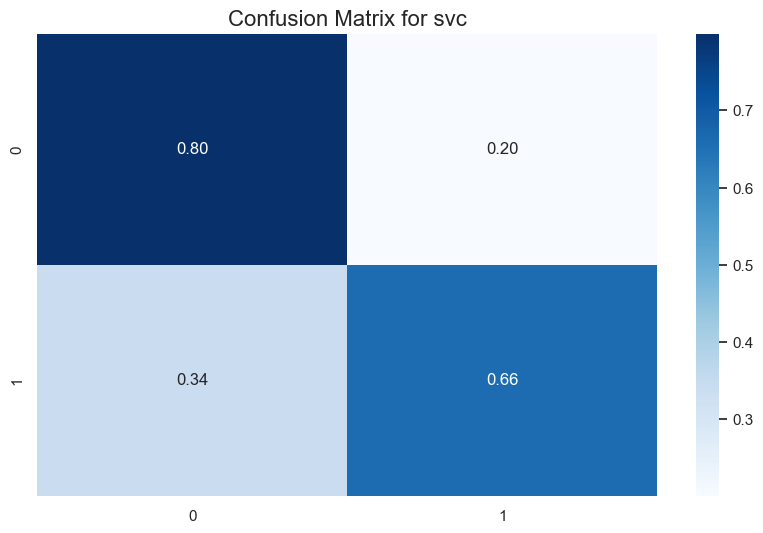

In [33]:
for name in results_uncalibrated:
    cm = results_uncalibrated[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}", fontsize=16)
    plt.show()

Model Calibration: isotonic, platt scaling

In [34]:
calibrated_models_isotonic = {}
calibrated_models_platt = {}

for name, model in models.items():
    print(f"Calibrating model: {name} with isotonic regression")
    iso_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic')
    iso_calibrator.fit(X_validation, y_validation)
    calibrated_models_isotonic[name] = iso_calibrator
    
    print(f"Calibrating model: {name} with Platt scaling")
    platt_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='sigmoid')
    platt_calibrator.fit(X_validation, y_validation)
    calibrated_models_platt[name] = platt_calibrator

Calibrating model: logistic_regression with isotonic regression
Calibrating model: logistic_regression with Platt scaling
Calibrating model: knn with isotonic regression
Calibrating model: knn with Platt scaling
Calibrating model: random_forest with isotonic regression
Calibrating model: random_forest with Platt scaling
Calibrating model: xgboost with isotonic regression
Calibrating model: xgboost with Platt scaling
Calibrating model: svc with isotonic regression
Calibrating model: svc with Platt scaling


In [35]:
results_calibrated_isotonic = {}
results_calibrated_platt = {}

for name, model in calibrated_models_isotonic.items():
    results_calibrated_isotonic[name] = get_results(model, X_test, y_test)

for name, model in calibrated_models_platt.items():    
    results_calibrated_platt[name] = get_results(model, X_test, y_test)

Calibration Curve

In [36]:
def display_calibration_curve(name, label, prob_true, prob_pred):
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.title(f"Calibration Curve — {name} - {label}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.grid()
    plt.show()

'Calibration Curves for logistic_regression:'

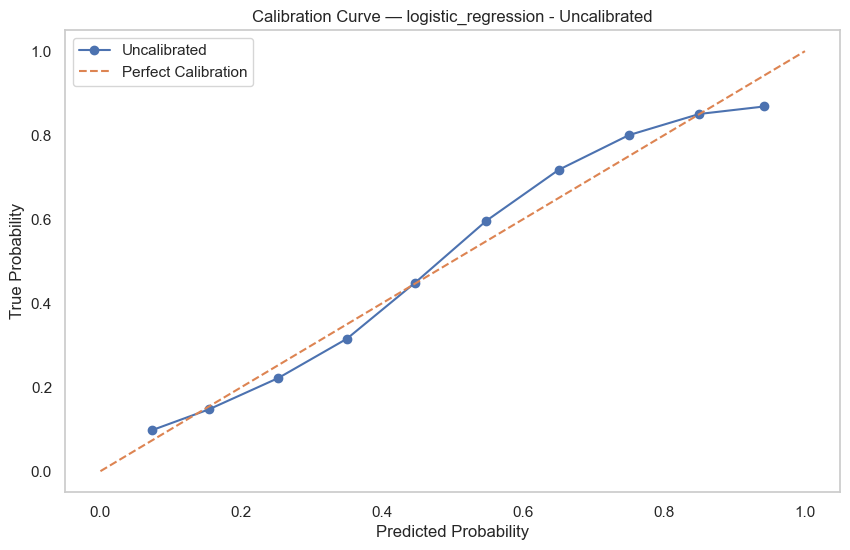

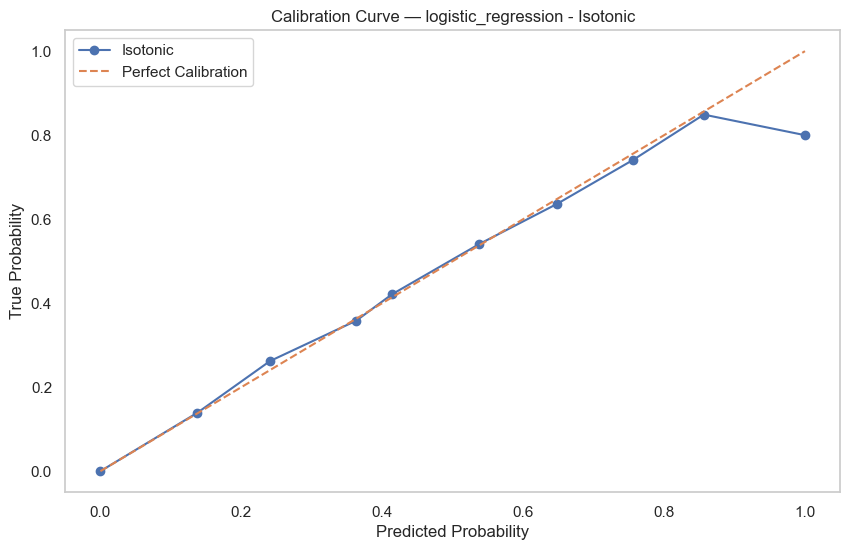

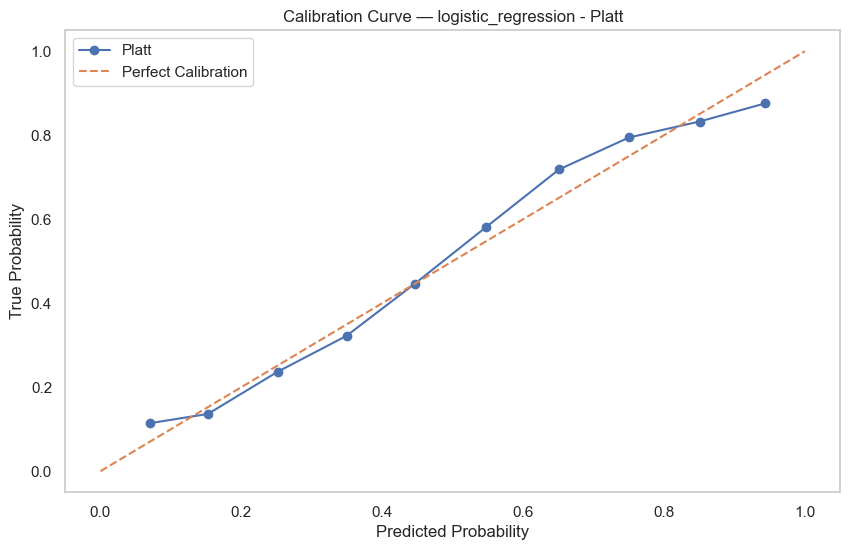

'Calibration Curves for knn:'

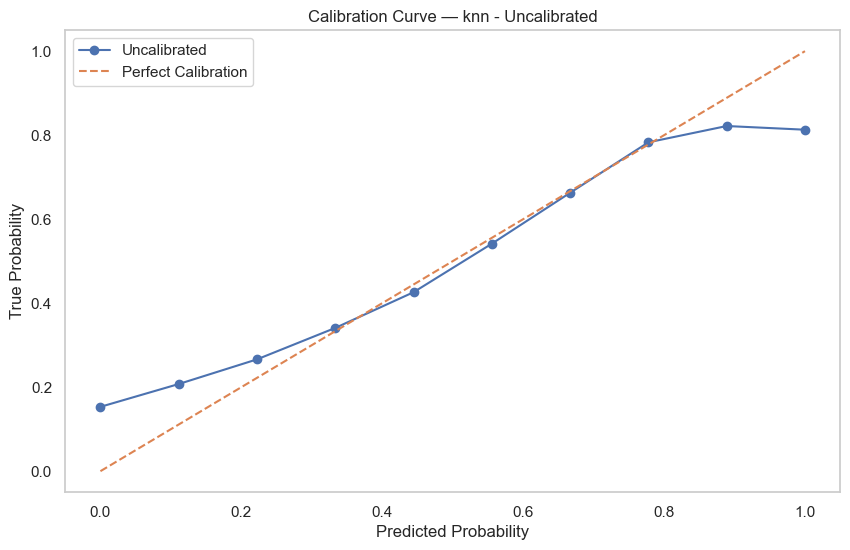

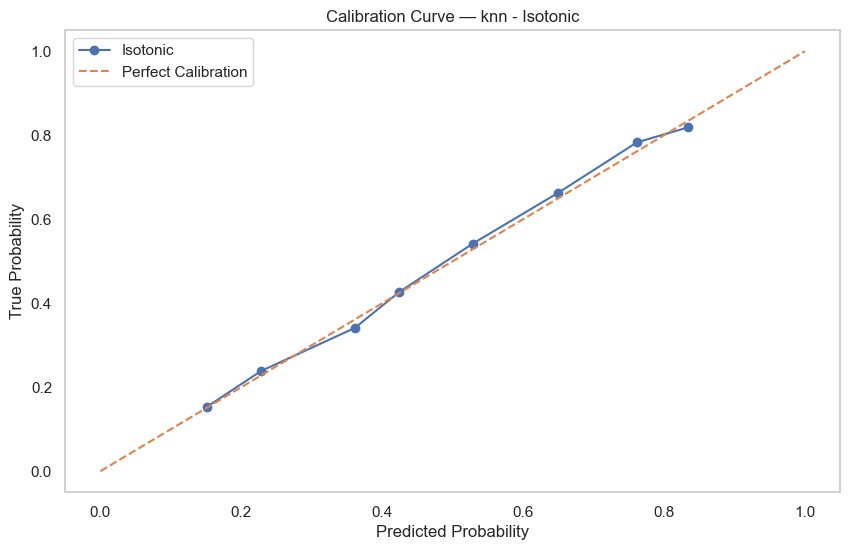

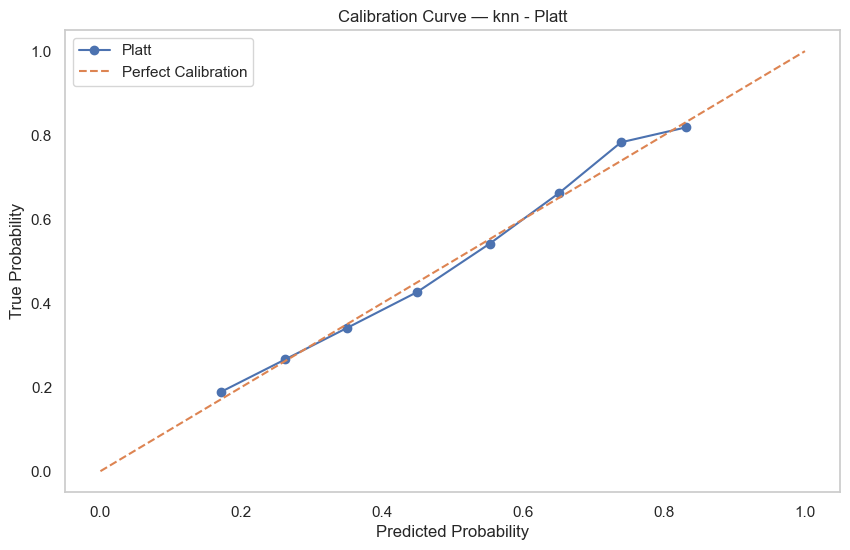

'Calibration Curves for random_forest:'

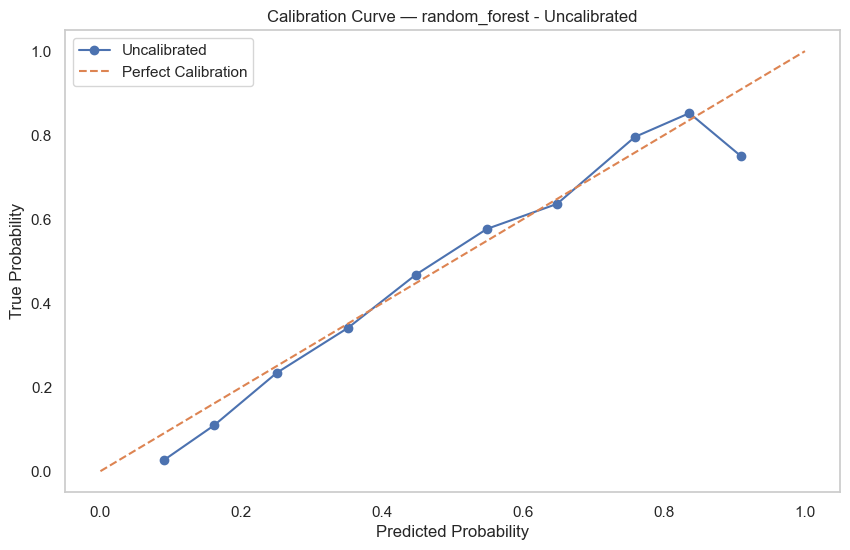

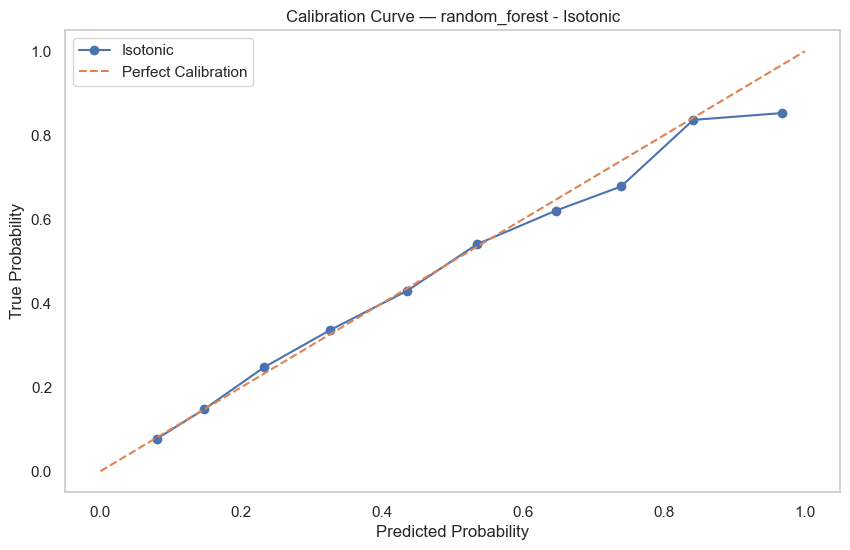

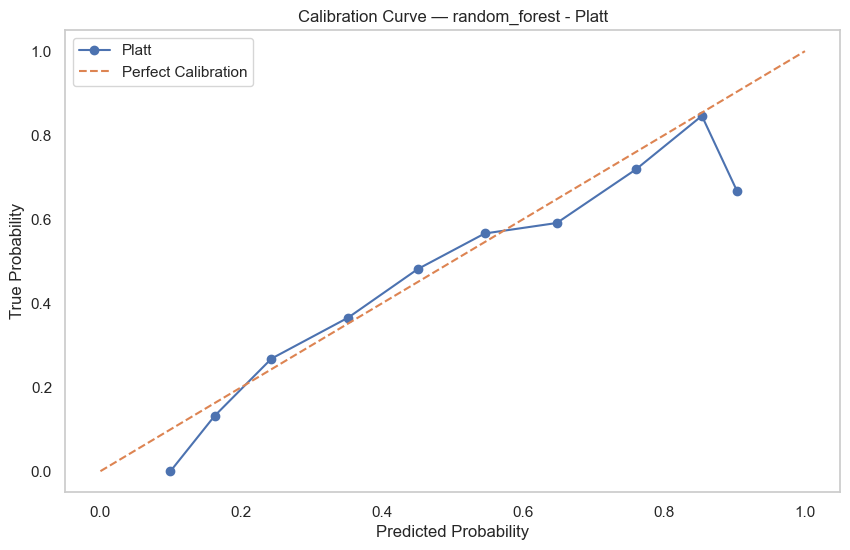

'Calibration Curves for xgboost:'

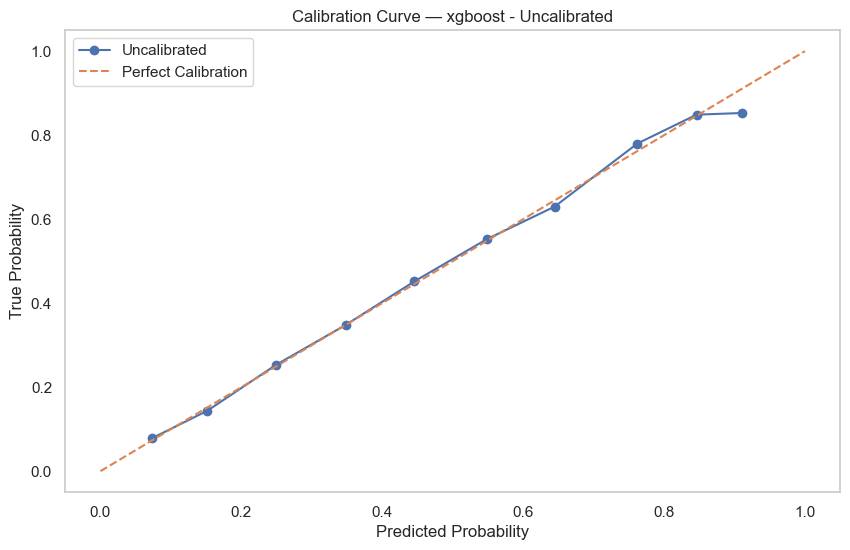

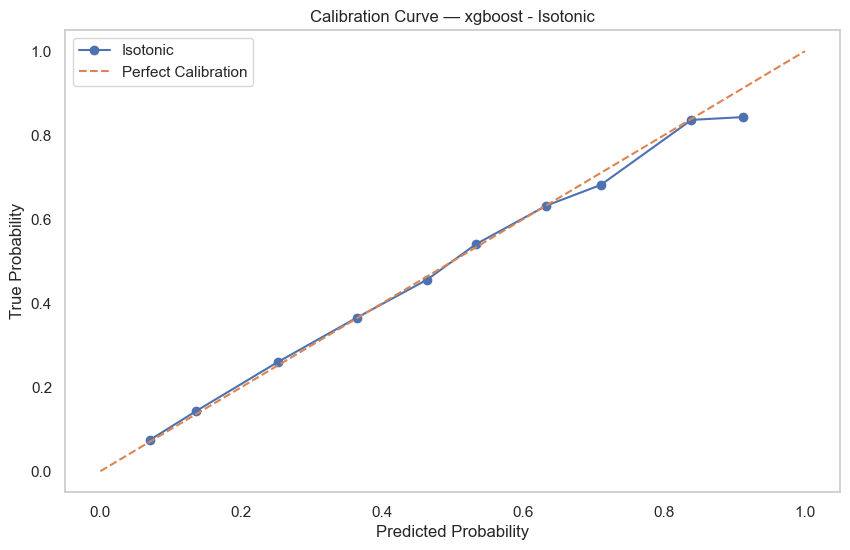

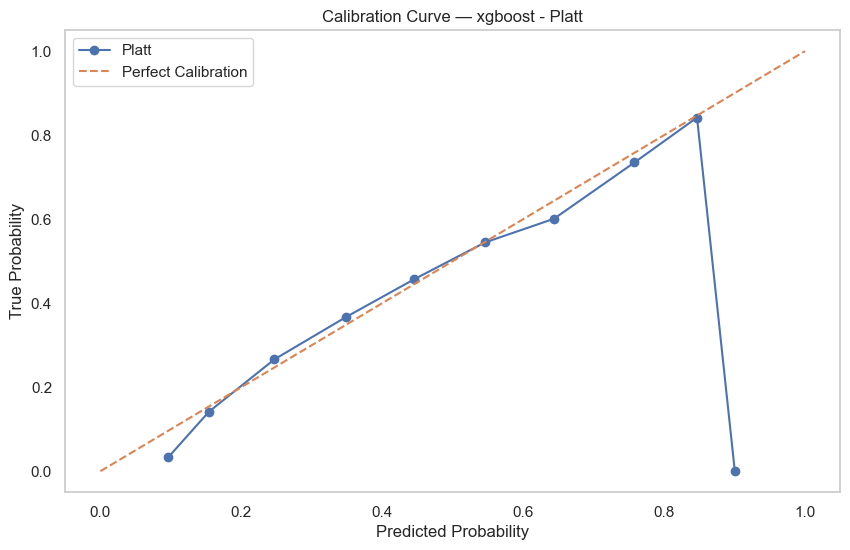

'Calibration Curves for svc:'

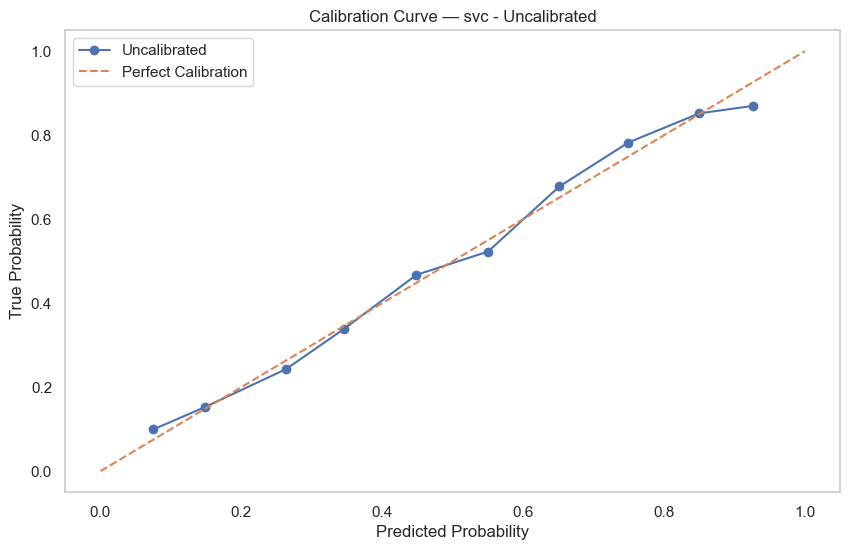

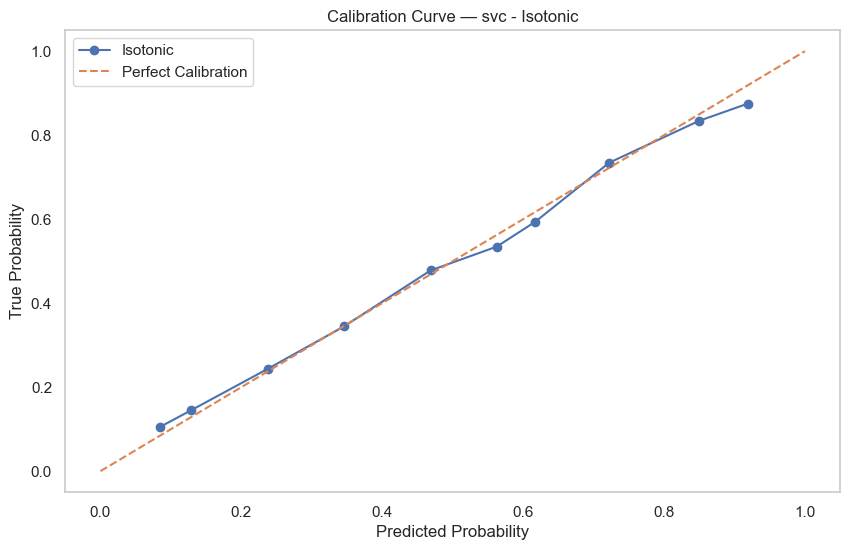

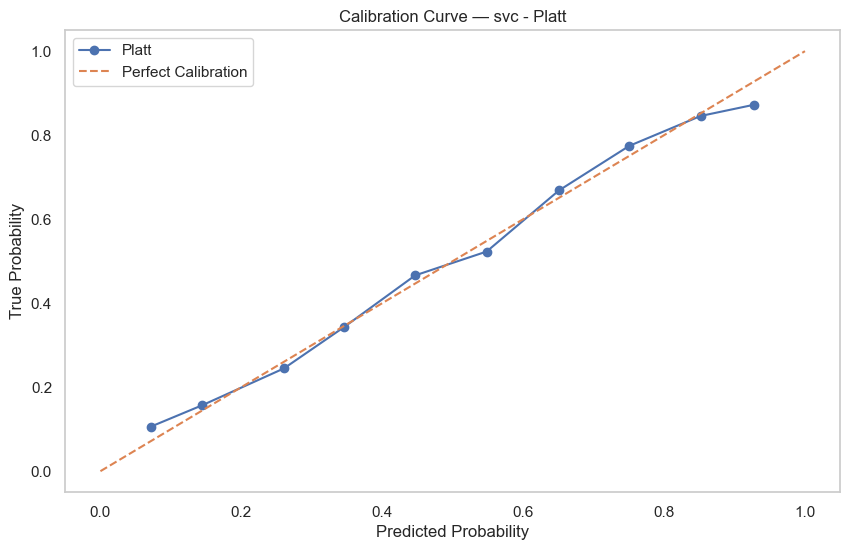

In [37]:
for name in model_names:
    display(f'Calibration Curves for {name}:')
    display_calibration_curve(name, 'Uncalibrated', results_uncalibrated[name]['prob_true'], results_uncalibrated[name]['prob_pred'])
    display_calibration_curve(name, 'Isotonic', results_calibrated_isotonic[name]['prob_true'], results_calibrated_isotonic[name]['prob_pred'])
    display_calibration_curve(name, 'Platt', results_calibrated_platt[name]['prob_true'], results_calibrated_platt[name]['prob_pred'])

Calibration Streatagy Comparison

In [38]:
for name in model_names:
    comparison = pd.DataFrame()

    comparison['Uncalibrated'] = results_uncalibrated[name]
    comparison['Isotonic'] = results_calibrated_isotonic[name]
    comparison['Platt'] = results_calibrated_platt[name]
    
    display(f'calibration Comparison for {name}:')
    display(comparison.loc[score_metrics])

'calibration Comparison for logistic_regression:'

,Uncalibrated,Isotonic,Platt
accuracy,0.727994,0.72945,0.727849
recall_score,0.664264,0.719435,0.6675
rmse,0.521542,0.520144,0.521681
r2,-0.088138,-0.082313,-0.08872
precision_score,0.756408,0.72996,0.754281
f1_score,0.707348,0.724659,0.708242
roc_auc,0.792033,0.791394,0.792033
brier_score,0.186758,0.185494,0.186437


'calibration Comparison for knn:'

,Uncalibrated,Isotonic,Platt
accuracy,0.71387,0.71387,0.71387
recall_score,0.686479,0.686479,0.686479
rmse,0.534912,0.534912,0.534912
r2,-0.144642,-0.144642,-0.144642
precision_score,0.721732,0.721732,0.721732
f1_score,0.703665,0.703665,0.703665
roc_auc,0.767164,0.767164,0.767164
brier_score,0.199818,0.194704,0.194981


'calibration Comparison for random_forest:'

,Uncalibrated,Isotonic,Platt
accuracy,0.732799,0.733382,0.73229
recall_score,0.657349,0.71561,0.666471
rmse,0.516914,0.516351,0.517407
r2,-0.068915,-0.066585,-0.070954
precision_score,0.769151,0.737752,0.762626
f1_score,0.708869,0.726512,0.711313
roc_auc,0.800709,0.799946,0.800709
brier_score,0.181402,0.181221,0.181371


'calibration Comparison for xgboost:'

,Uncalibrated,Isotonic,Platt
accuracy,0.735275,0.73542,0.735056
recall_score,0.684861,0.693394,0.691629
rmse,0.514514,0.514373,0.514727
r2,-0.059012,-0.05843,-0.059886
precision_score,0.757034,0.752515,0.752883
f1_score,0.719141,0.721746,0.720957
roc_auc,0.800723,0.79998,0.800723
brier_score,0.180587,0.180886,0.180828


'calibration Comparison for svc:'

,Uncalibrated,Isotonic,Platt
accuracy,0.730251,0.730178,0.730542
recall_score,0.659997,0.664558,0.684861
rmse,0.519373,0.519444,0.519093
r2,-0.079109,-0.0794,-0.077944
precision_score,0.762925,0.760054,0.749115
f1_score,0.707738,0.709105,0.715548
roc_auc,0.79464,0.792596,0.794642
brier_score,0.18387,0.184029,0.183795


update models with calibration

In [39]:
final_models = {}
final_results = {}

for name in model_names:
    uncalibrated_brier = results_uncalibrated[name]['brier_score']
    iso_brier = results_calibrated_isotonic[name]['brier_score']
    platt_brier = results_calibrated_platt[name]['brier_score']
    
    if uncalibrated_brier <= iso_brier and uncalibrated_brier <= platt_brier:
        final_models[name] = models[name]
        final_results[name] = results_uncalibrated[name]
    elif iso_brier <= uncalibrated_brier and iso_brier <= platt_brier:
        final_models[name] = calibrated_models_isotonic[name]
        final_results[name] = results_calibrated_isotonic[name]
    elif platt_brier <= uncalibrated_brier and platt_brier <= iso_brier:
        final_models[name] = calibrated_models_platt[name]
        final_results[name] = results_calibrated_platt[name]

Fairness Evaluation

In [40]:
#age group fairness evaluation
age_group_results = {}

test_data['age_group'] = pd.cut(
    test_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

for name in model_names:
    model = final_models[name]
    result = pd.DataFrame()

    for group in age_group_labels:
        group_indices = test_data[test_data['age_group'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        if len(y_group) == 0:
            continue
        
        result[group] = get_results(model, X_group, y_group)
        
    age_group_results[name] = {}
    age_group_results[name]['results'] = result
    age_group_results[name]['EOD'] = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    
    display("Age Group Performance for Model: " + name) 
    display(result.loc[score_metrics])
    display(f"Equal Opportunity Difference (EOD): {age_group_results[name]['EOD']:.4f}")

'Age Group Performance for Model: logistic_regression'

,<45,45-49,50-54,55-59,60-64
accuracy,0.8116,0.759221,0.710816,0.679614,0.711319
recall_score,0.528402,0.616371,0.678715,0.760288,0.899178
rmse,0.43405,0.490692,0.537758,0.566026,0.537291
r2,0.121384,0.011725,-0.157015,-0.305517,-0.362424
precision_score,0.798403,0.764994,0.718276,0.700806,0.740923
f1_score,0.63593,0.682687,0.697935,0.729336,0.812416
roc_auc,0.810008,0.794943,0.761119,0.740091,0.706141
brier_score,0.148105,0.175589,0.195874,0.204519,0.192189


'Equal Opportunity Difference (EOD): 0.3708'

'Age Group Performance for Model: knn'

,<45,45-49,50-54,55-59,60-64
accuracy,0.798026,0.746788,0.691895,0.669977,0.684839
recall_score,0.570674,0.604536,0.631096,0.719136,0.838686
rmse,0.449416,0.503202,0.555072,0.574477,0.561392
r2,0.058078,-0.039305,-0.232718,-0.344789,-0.487395
precision_score,0.722408,0.744836,0.710594,0.705348,0.741744
f1_score,0.637638,0.667392,0.66849,0.712175,0.787242
roc_auc,0.796176,0.766019,0.741844,0.709293,0.650471
brier_score,0.155748,0.184373,0.203178,0.214955,0.205234


'Equal Opportunity Difference (EOD): 0.2680'

'Age Group Performance for Model: random_forest'

,<45,45-49,50-54,55-59,60-64
accuracy,0.815714,0.759221,0.712511,0.690713,0.711319
recall_score,0.593131,0.633136,0.646013,0.72428,0.925317
rmse,0.429286,0.490692,0.53618,0.556136,0.537291
r2,0.140568,0.011725,-0.150235,-0.260294,-0.362424
precision_score,0.762309,0.754407,0.737394,0.729156,0.730973
f1_score,0.667162,0.688472,0.688685,0.72671,0.816744
roc_auc,0.825588,0.796538,0.768228,0.743847,0.708894
brier_score,0.140553,0.17298,0.191988,0.201406,0.187197


'Equal Opportunity Difference (EOD): 0.3322'

'Age Group Performance for Model: xgboost'

,<45,45-49,50-54,55-59,60-64
accuracy,0.816125,0.763365,0.717311,0.688376,0.714434
recall_score,0.577279,0.605523,0.604131,0.680556,0.917102
rmse,0.428806,0.486451,0.531685,0.558233,0.534384
r2,0.142486,0.028735,-0.131027,-0.269814,-0.347722
precision_score,0.774823,0.782166,0.771994,0.74788,0.736653
f1_score,0.66162,0.682601,0.677824,0.712631,0.817033
roc_auc,0.825745,0.799505,0.768382,0.744157,0.710063
brier_score,0.139937,0.172343,0.191437,0.201049,0.185902


'Equal Opportunity Difference (EOD): 0.3398'

'Age Group Performance for Model: svc'

,<45,45-49,50-54,55-59,60-64
accuracy,0.813246,0.762122,0.711946,0.683995,0.703531
recall_score,0.595773,0.612426,0.628801,0.694959,0.848394
rmse,0.432151,0.487728,0.536707,0.562143,0.54449
r2,0.129058,0.023632,-0.152495,-0.287665,-0.39918
precision_score,0.752922,0.774314,0.746086,0.734239,0.755319
f1_score,0.665192,0.683921,0.682441,0.714059,0.799156
roc_auc,0.806064,0.793923,0.766795,0.74166,0.707462
brier_score,0.147479,0.175117,0.193588,0.202525,0.1892


'Equal Opportunity Difference (EOD): 0.2526'

In [41]:
# gender fairness evaluation
gender_group_results = {}

gender_groups = test_data['gender'].unique()

for name in model_names:
    model = final_models[name]
    result = pd.DataFrame()

    for group in gender_groups:
        group_indices = test_data[test_data['gender'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        if len(y_group) == 0:
            continue
        
        result[group] = get_results(model, X_group, y_group)
        
    gender_group_results[name] = {}
    gender_group_results[name]['results'] = result
    gender_group_results[name]['EOD'] = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    
    display("Gender Group Performance for Model: " + name) 
    display(result.loc[score_metrics])
    display(f"Equal Opportunity Difference (EOD): {gender_group_results[name]['EOD']:.4f}")

'Gender Group Performance for Model: logistic_regression'

,0,1
accuracy,0.731694,0.725261
recall_score,0.718537,0.721086
rmse,0.517983,0.524156
r2,-0.073492,-0.098956
precision_score,0.731499,0.727158
f1_score,0.72496,0.724109
roc_auc,0.795022,0.784453
brier_score,0.183904,0.188464


'Equal Opportunity Difference (EOD): 0.0025'

'Gender Group Performance for Model: knn'

,0,1
accuracy,0.719173,0.703967
recall_score,0.693094,0.674322
rmse,0.529931,0.54409
r2,-0.123588,-0.184134
precision_score,0.724359,0.716822
f1_score,0.708382,0.694923
roc_auc,0.773076,0.755926
brier_score,0.192237,0.199311


'Equal Opportunity Difference (EOD): 0.0188'

'Gender Group Performance for Model: random_forest'

,0,1
accuracy,0.737172,0.726305
recall_score,0.720127,0.707307
rmse,0.512668,0.523159
r2,-0.051575,-0.094781
precision_score,0.7391,0.735243
f1_score,0.72949,0.721004
roc_auc,0.804191,0.791764
brier_score,0.179591,0.184266


'Equal Opportunity Difference (EOD): 0.0128'

'Gender Group Performance for Model: xgboost'

,0,1
accuracy,0.737954,0.730271
recall_score,0.690595,0.674322
rmse,0.511904,0.519354
r2,-0.048444,-0.078914
precision_score,0.755843,0.759285
f1_score,0.721747,0.714286
roc_auc,0.805044,0.79231
brier_score,0.178686,0.184139


'Equal Opportunity Difference (EOD): 0.0163'

'Gender Group Performance for Model: svc'

,0,1
accuracy,0.734041,0.724008
recall_score,0.688551,0.678079
rmse,0.515712,0.525349
r2,-0.064099,-0.103967
precision_score,0.750433,0.746667
f1_score,0.718161,0.710722
roc_auc,0.799637,0.785199
brier_score,0.181744,0.187624


'Equal Opportunity Difference (EOD): 0.0105'

***SHAP Explainability Analysis***

In [42]:
def get_shap_summary_df(shap_values, feature_names):
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_summary_df = pd.DataFrame({
        'mean_abs_shap': np.abs(shap_df).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)
    
    return shap_summary_df

Logistic Regression

/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


'Shap Summary Plot for logistic regression'

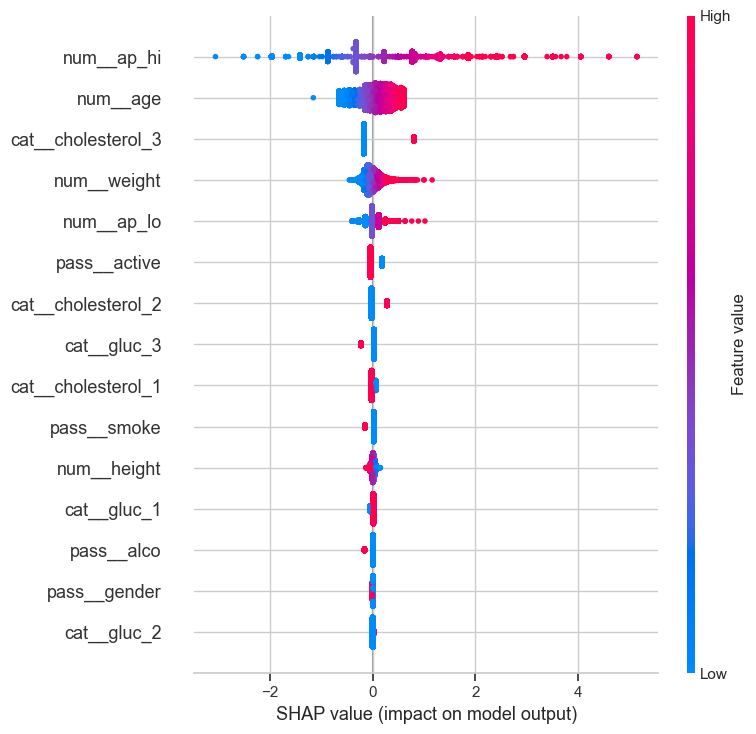

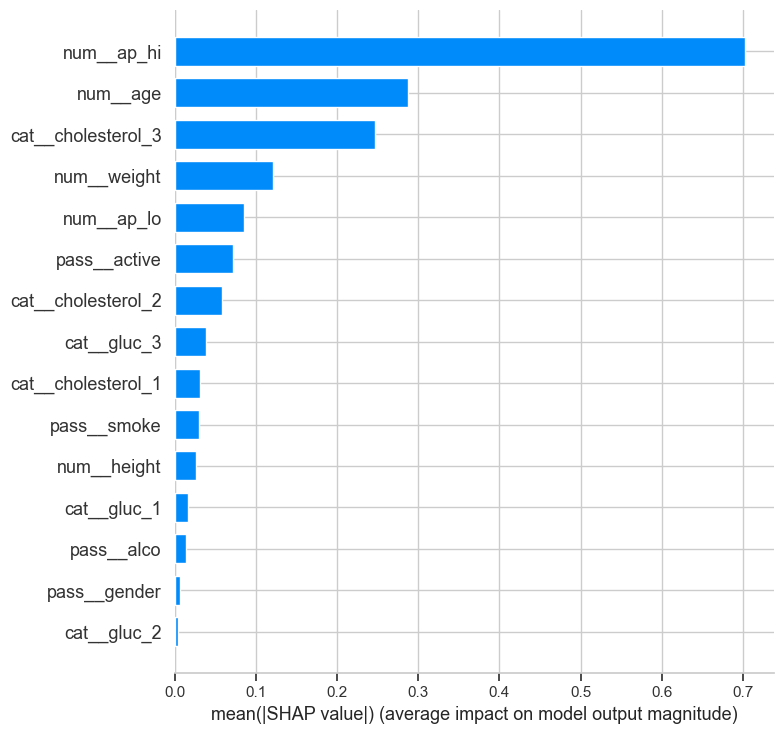

,Feature,Coefficient
7,cat__cholesterol_3,0.975078
3,num__ap_hi,0.917027
0,num__age,0.340848
6,cat__cholesterol_2,0.302012
2,num__weight,0.156475
4,num__ap_lo,0.122136
8,cat__gluc_1,0.061411
9,cat__gluc_2,0.025349
11,pass__gender,-0.013710
1,num__height,-0.032503


,mean_abs_shap
num__ap_hi,0.703380
num__age,0.287604
cat__cholesterol_3,0.246484
num__weight,0.120366
num__ap_lo,0.085226
pass__active,0.071660
cat__cholesterol_2,0.057685
cat__gluc_3,0.038568
cat__cholesterol_1,0.030792
pass__smoke,0.029990


In [43]:
preprocessor_lr = models['logistic_regression'].named_steps['pre']
model_lr = models['logistic_regression'].named_steps['model']

X_train_ = preprocessor_lr.transform(X_train)
X_test_ = preprocessor_lr.transform(X_test)
feature_names_lr = preprocessor_lr.get_feature_names_out()

explainer_lr = shap.LinearExplainer(model_lr, X_train_, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_)

display(f"Shap Summary Plot for logistic regression")
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr)
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr, plot_type="bar")
            
coefficients_df = pd.DataFrame({'Feature': feature_names_lr, 'Coefficient': model_lr.coef_[0]})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
display(coefficients_df)
            
display(get_shap_summary_df(shap_values_lr, feature_names_lr))

XGBoost

'Shap Summary Plot for XGBoost'

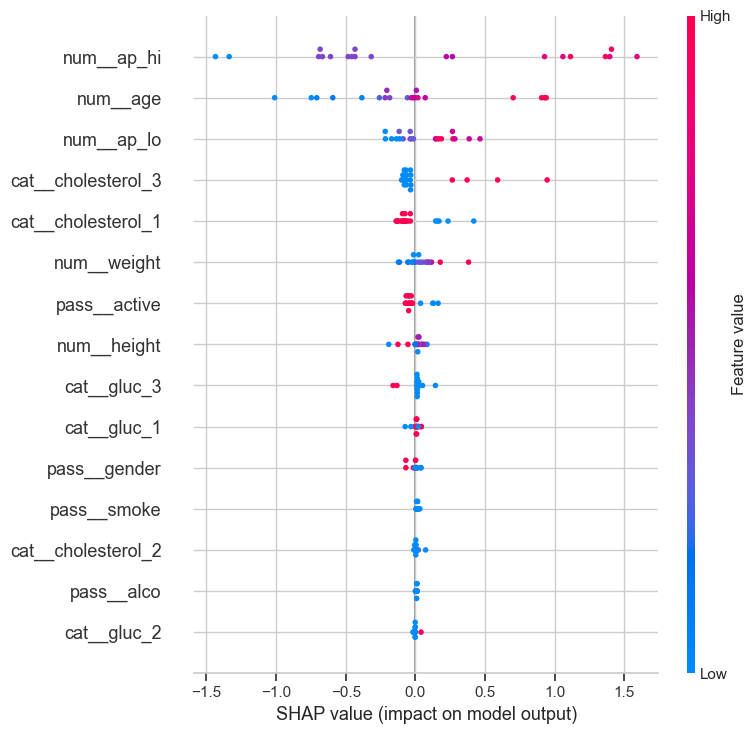

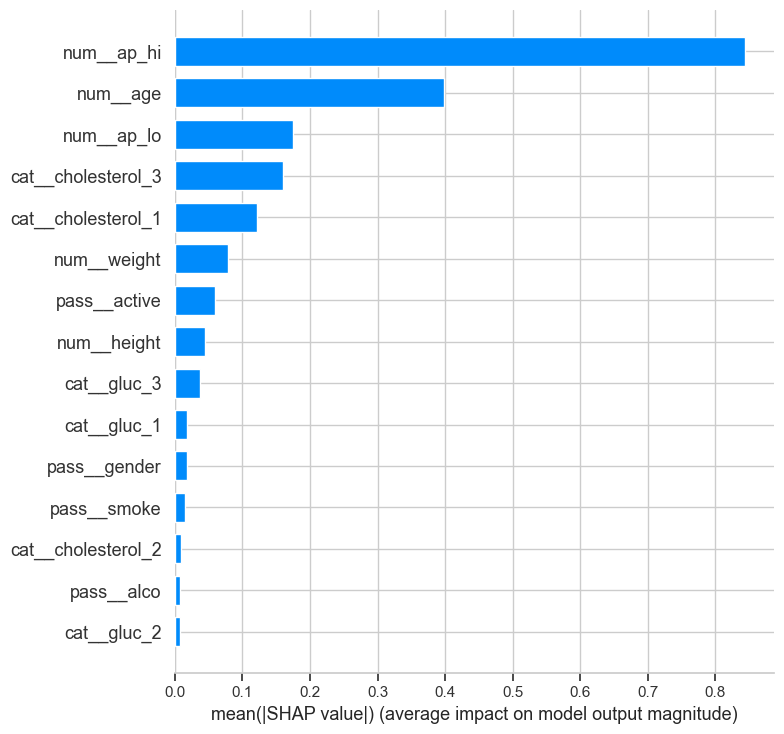

,mean_abs_shap
num__ap_hi,0.844763
num__age,0.398949
num__ap_lo,0.174809
cat__cholesterol_3,0.159291
cat__cholesterol_1,0.121900
num__weight,0.078704
pass__active,0.058598
num__height,0.044854
cat__gluc_3,0.037488
cat__gluc_1,0.018236


In [44]:
preprocessor_xgb = models['xgboost'].named_steps['pre']
model_xgb = models['xgboost'].named_steps['model']

samples = shap.sample(X_test, nsamples=20, random_state=42)
samples = preprocessor_xgb.transform(samples)
feature_names_xgb = preprocessor_xgb.get_feature_names_out()

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(samples)

display(f"Shap Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, samples, feature_names=feature_names_xgb)
shap.summary_plot(shap_values_xgb, samples, feature_names=feature_names_xgb, plot_type="bar")

display(get_shap_summary_df(shap_values_xgb, feature_names_xgb))
